In [1]:
import torch,torchvision,os,time
import torchvision.transforms as transforms
import numpy as np
from utils.util import get_loader,evaluate
from utils.layer import qConv2d,qLinear
from utils.train import QAVAT_train
import matplotlib.pyplot as plt
import torchvision.models as models             

from mqbench.prepare_by_platform import prepare_by_platform   # add quant nodes for specific Backend
from mqbench.prepare_by_platform import BackendType           # contain various Backend, like TensorRT, NNIE, etc.
from mqbench.utils.state import enable_calibration            # turn on calibration algorithm, determine scale, zero_point, etc.
from mqbench.utils.state import enable_quantization           # turn on actually quantization, like FP32 -> INT8
from mqbench.utils.state import disable_all           
from copy import deepcopy
from mqbench.advanced_ptq import ptq_reconstruction
torch.manual_seed(0)
np.random.seed(0)

In [2]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


def evaluate(val_loader, model,
             criterion = torch.nn.CrossEntropyLoss().cuda(),device='cuda'):
    s_time = time.time()
    # switch to evaluate mode
    model.eval()
    count,top1,top5,losses = 0,0,0,0
    correct = 0
    with torch.no_grad():
        for i, (images, target) in enumerate(val_loader):
            images, target = images.to(device), target.to(device)
            # compute output
            output = model(images)
            loss = criterion(output, target)
            # measure accuracy and record loss
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses = losses * count/(count+images.size(0)) + loss * images.size(0)/(count+images.size(0))
            top1 = top1 * count/(count+images.size(0)) + acc1 * images.size(0)/(count+images.size(0))
            top5 = top5 * count/(count+images.size(0)) + acc5 * images.size(0)/(count+images.size(0))
            count += images.size(0)
            #correct += acc1 * images.size(0)
    test_time = time.time() - s_time
    #print(f'correct: {correct}/{count}')
    
    return {'top1':top1,'top5':top5,'loss':losses,'time':test_time}

    

In [3]:
adv_ptq = False
dataset = 'cifar100'
modelname = 'resnet20'
mn = dataset.lower()+ '_' + modelname
model = torch.hub.load("chenyaofo/pytorch-cifar-models", mn, pretrained=True).cuda()
# model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_mobilenetv2_x0_5", pretrained=True).cuda()
model.eval()
torch.manual_seed(0)
np.random.seed(0)
train,test = get_loader(dataset.upper(),batch_size=512,test_batch_size=128)
train.num_workers = 4
test.num_workers = 4
train.pin_in_memory = True
test.pin_in_memory = True

Using cache found in /homes/zdeng/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Files already downloaded and verified
Files already downloaded and verified


In [4]:
evaluate(train,model)

{'top1': tensor([68.2580], device='cuda:0'),
 'top5': tensor([89.8000], device='cuda:0'),
 'loss': tensor(1.2267, device='cuda:0'),
 'time': 4.645220756530762}

In [5]:
evaluate(test,model)

{'top1': tensor([68.8300], device='cuda:0'),
 'top5': tensor([91.0100], device='cuda:0'),
 'loss': tensor(1.2252, device='cuda:0'),
 'time': 0.9335129261016846}

In [6]:
# calibration data used to calibrate PTQ and MPQ
calib_data = []
stacked_tensor = []
calib_fp_output = []
i = 0
with torch.no_grad():
    for img,label in train:
        i += 1
        # stacked_tensor is to calibrate the model
        # calib_data (part of it, as defined later) is the data to calculate ltilde
        if i<= 2:
            stacked_tensor.append(img)
            
        calib_data.append((img,label))
        calib_fp_output.append(model(img.cuda()))


In [7]:
MPQ_scheme = (2,4,8)
model.eval()

CifarResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias

In [8]:
# configuration
ptq_reconstruction_config_init = {
    'pattern': 'block',                   #? 'layer' for Adaround or 'block' for BRECQ and QDROP
    'scale_lr': 4.0e-5,                   #? learning rate for learning step size of activation
    'warm_up': 0.2,                       #? 0.2 * max_count iters without regularization to floor or ceil
    'weight': 0.01,                       #? loss weight for regularization item
    'max_count': 1,                   #? optimization iteration
    'b_range': [20,2],                    #? beta decaying range
    'keep_gpu': True,                     #? calibration data restore in gpu or cpu
    'round_mode': 'learned_hard_sigmoid', #? ways to reconstruct the weight, currently only support learned_hard_sigmoid
    'prob': 0.5,                          #? dropping probability of QDROP, 1.0 for Adaround and BRECQ
}


ptq_reconstruction_config = {
    'pattern': 'block',                   #? 'layer' for Adaround or 'block' for BRECQ and QDROP
    'scale_lr': 4.0e-5,                   #? learning rate for learning step size of activation
    'warm_up': 0.2,                       #? 0.2 * max_count iters without regularization to floor or ceil
    'weight': 0.01,                       #? loss weight for regularization item
    'max_count': 20000,                   #? optimization iteration
    'b_range': [20,2],                    #? beta decaying range
    'keep_gpu': True,                     #? calibration data restore in gpu or cpu
    'round_mode': 'learned_hard_sigmoid', #? ways to reconstruct the weight, currently only support learned_hard_sigmoid
    'prob': 0.5,                          #? dropping probability of QDROP, 1.0 for Adaround and BRECQ
}

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
ptq_reconstruction_config = dotdict(ptq_reconstruction_config)
ptq_reconstruction_config_init = dotdict(ptq_reconstruction_config_init)

def getModuleByName(model,moduleName):
    '''
        replace module with name modelName.moduleName with newModule
    '''
    tokens = moduleName.split('.')
    m = model
    for tok in tokens:
        m = getattr(m,tok)
    return m

for b in MPQ_scheme:
    mqb_fp_model = deepcopy(model)
    
    # MSE calibration on model parameters
    backend = BackendType.Academic
    extra_config = {
        'extra_qconfig_dict': {
            'w_observer': 'MSEObserver',                              # custom weight observer
            'a_observer': 'EMAMSEObserver',                              # custom activation observer
            'w_fakequantize': 'AdaRoundFakeQuantize' if adv_ptq else 'FixedFakeQuantize',
            'a_fakequantize': 'QDropFakeQuantize' if adv_ptq else 'FixedFakeQuantize',
            'w_qscheme': {
                'bit': b,                                             # custom bitwidth for weight,
                'symmetry': True,                                    # custom whether quant is symmetric for weight,
                'per_channel': False,                                  # custom whether quant is per-channel or per-tensor for weight,
                'pot_scale': False,                                   # custom whether scale is power of two for weight.
            },
            'a_qscheme': {
                'bit': 8,                                             # custom bitwidth for activation,
                'symmetry': False,                                    # custom whether quant is symmetric for activation,
                'per_channel': False,                                  # custom whether quant is per-channel or per-tensor for activation,
                'pot_scale': False,                                   # custom whether scale is power of two for activation.
            }
        }                                                         # custom tracer behavior, checkout https://github.com/pytorch/pytorch/blob/efcbbb177eacdacda80b94ad4ce34b9ed6cf687a/torch/fx/_symbolic_trace.py#L836
    }
    print(f'Prepare {b}bits model using MQBench')

    exec(f'mqb_{b}bits_model=prepare_by_platform(mqb_fp_model, backend,extra_config).cuda()')
    
    # calibration loop
    enable_calibration(eval(f'mqb_{b}bits_model'))
    for img in stacked_tensor:
        eval(f'mqb_{b}bits_model')(img.cuda())
    
    if adv_ptq:
        if os.path.exists(f'QDROP_{b}bits_{mn}.pt'):
            exec(f'mqb_{b}bits_model=ptq_reconstruction(mqb_{b}bits_model, stacked_tensor, ptq_reconstruction_config_init).cuda()')
            print(f'QDROP model already saved, now loading QDROP_{b}bits_{mn}.pt')
            load_from = f'QDROP_{b}bits_{mn}.pt'
            exec(f'mqb_{b}bits_model.load_state_dict(torch.load(load_from))')
        else:
            
            exec(f'mqb_{b}bits_model=ptq_reconstruction(mqb_{b}bits_model, stacked_tensor, ptq_reconstruction_config).cuda()')
            print(f'saving QDROP tuned model: QDROP_{b}bits_{mn}.pt...')
            torch.save(eval(f'mqb_{b}bits_model').state_dict(),f'QDROP_{b}bits_{mn}.pt')

Prepare 2bits model using MQBench
[MQBENCH] INFO: Quantize model Scheme: BackendType.Academic Mode: Eval
[MQBENCH] INFO: Weight Qconfig:
    FakeQuantize: FixedFakeQuantize Params: {}
    Oberver:      MSEObserver Params: Symmetric: True / Bitwidth: 2 / Per channel: False / Pot scale: False / Extra kwargs: {}
[MQBENCH] INFO: Activation Qconfig:
    FakeQuantize: FixedFakeQuantize Params: {}
    Oberver:      EMAMSEObserver Params: Symmetric: False / Bitwidth: 8 / Per channel: False / Pot scale: False / Extra kwargs: {}
[MQBENCH] INFO: Replace module to qat module.
[MQBENCH] INFO: Set layer conv1 to 8 bit.
[MQBENCH] INFO: Set layer fc to 8 bit.
dbg node_to_quantize_output
 odict_keys([x, relu, layer1_0_relu, layer1_0_relu_1, layer1_1_relu, layer1_1_relu_1, layer1_2_relu, layer1_2_relu_1, layer2_0_relu, layer2_0_relu_1, layer2_1_relu, layer2_1_relu_1, layer2_2_relu, layer2_2_relu_1, layer3_0_relu, layer3_0_relu_1, layer3_1_relu, layer3_1_relu_1, layer3_2_relu, view])
[MQBENCH] INFO: Set 

In [9]:
for b in MPQ_scheme: 
    disable_all(eval(f'mqb_{b}bits_model'))
    # evaluation loop
    enable_quantization(eval(f'mqb_{b}bits_model'))
    eval(f'mqb_{b}bits_model').eval()
    print('evaluate mqb quantized model')
    print(evaluate(test,eval(f'mqb_{b}bits_model')))

[MQBENCH] INFO: Disable observer and Disable quantize.
[MQBENCH] INFO: Disable observer and Enable quantize.
evaluate mqb quantized model
{'top1': tensor([1.0000], device='cuda:0'), 'top5': tensor([6.5700], device='cuda:0'), 'loss': tensor(5.5152, device='cuda:0'), 'time': 1.3825855255126953}
[MQBENCH] INFO: Disable observer and Disable quantize.
[MQBENCH] INFO: Disable observer and Enable quantize.
evaluate mqb quantized model
{'top1': tensor([52.5200], device='cuda:0'), 'top5': tensor([79.2800], device='cuda:0'), 'loss': tensor(2.1109, device='cuda:0'), 'time': 1.3786933422088623}
[MQBENCH] INFO: Disable observer and Disable quantize.
[MQBENCH] INFO: Disable observer and Enable quantize.
evaluate mqb quantized model
{'top1': tensor([68.5700], device='cuda:0'), 'top5': tensor([90.7200], device='cuda:0'), 'loss': tensor(1.2359, device='cuda:0'), 'time': 1.391451358795166}


In [10]:
mqb_fp_model = deepcopy(mqb_8bits_model)
disable_all(mqb_fp_model)
mqb_mix_model = deepcopy(mqb_fp_model)

# 1. record all modules we want to consider
types_to_quant = (torch.nn.Conv2d,torch.nn.Linear)

layer_input_map = {}

for node in mqb_8bits_model.graph.nodes:
    try:
        node_target = getModuleByName(mqb_mix_model,node.target)
        if isinstance(node_target,types_to_quant):
            node_args = node.args[0]
            print('input of ',node.target,' is ',node_args)
            layer_input_map[node.target] = str(node_args.target)
    except:
        continue

[MQBENCH] INFO: Disable observer and Disable quantize.
input of  conv1  is  x_post_act_fake_quantizer
input of  layer1.0.conv1  is  relu_post_act_fake_quantizer
input of  layer1.0.conv2  is  layer1_0_relu_post_act_fake_quantizer
input of  layer1.1.conv1  is  layer1_0_relu_1_post_act_fake_quantizer
input of  layer1.1.conv2  is  layer1_1_relu_post_act_fake_quantizer
input of  layer1.2.conv1  is  layer1_1_relu_1_post_act_fake_quantizer
input of  layer1.2.conv2  is  layer1_2_relu_post_act_fake_quantizer
input of  layer2.0.conv1  is  layer1_2_relu_1_post_act_fake_quantizer
input of  layer2.0.conv2  is  layer2_0_relu_post_act_fake_quantizer
input of  layer2.0.downsample.0  is  layer1_2_relu_1_post_act_fake_quantizer
input of  layer2.1.conv1  is  layer2_0_relu_1_post_act_fake_quantizer
input of  layer2.1.conv2  is  layer2_1_relu_post_act_fake_quantizer
input of  layer2.2.conv1  is  layer2_1_relu_1_post_act_fake_quantizer
input of  layer2.2.conv2  is  layer2_2_relu_post_act_fake_quantizer
inpu

In [11]:
# ref_metric = ('loss',evaluate(calib_data,mqb_fp_model)['loss'])

In [12]:
def perturb(perturb_scheme):
    # perturb_scheme: {layer_name:(act_bits,weight_bits)}
    for layer_name in perturb_scheme:
        a_bits,w_bits = perturb_scheme[layer_name]
        
        if w_bits is not None:
            mix_module = getModuleByName(mqb_mix_model,layer_name)
            tar_module = getModuleByName(eval(f'mqb_{w_bits}bits_model'),layer_name)
            # replace weight quant to use w_bits quantization
            w_cmd = f'mix_module.weight_fake_quant=tar_module.weight_fake_quant'
            exec(w_cmd)
        
        if a_bits is not None:
        
            # replace act quant to use a_bits quantization
            a_cmd = f'mqb_mix_model.{layer_input_map[layer_name]}=mqb_{a_bits}bits_model.{layer_input_map[layer_name]}'
            exec(a_cmd)
        
        #print(layer_name)
        #print(a_cmd)
        #print(w_cmd)


In [13]:
# perturb functionality test
perturb_scheme = {}
for layer_name in layer_input_map:
    perturb_scheme[layer_name] = (8,8)
perturb(perturb_scheme)

In [14]:
evaluate(test,mqb_mix_model)

{'top1': tensor([68.5700], device='cuda:0'),
 'top5': tensor([90.7200], device='cuda:0'),
 'loss': tensor(1.2359, device='cuda:0'),
 'time': 1.5013399124145508}

In [124]:
mqb_mix_model = deepcopy(mqb_8bits_model)
disable_all(mqb_mix_model)
evaluate(test,mqb_mix_model)

[MQBENCH] INFO: Disable observer and Disable quantize.


{'top1': tensor([68.8300], device='cuda:0'),
 'top5': tensor([91.0100], device='cuda:0'),
 'loss': tensor(1.2252, device='cuda:0'),
 'time': 1.3546984195709229}

## CLADO

In [16]:
import torch.nn.functional as F
kl_loss = torch.nn.KLDivLoss(reduction="batchmean")
def kldiv(quant_logit,fp_logit):
    inp = F.log_softmax(quant_logit,dim=-1)
    tar = F.softmax(fp_logit,dim=-1)
    return kl_loss(inp,tar)

def perturb_loss(perturb_scheme,ref_metric,
                 eval_data=calib_data,printInfo=False,KL=False):
    
    global mqb_mix_model
    mqb_mix_model.eval()
    
    with torch.no_grad():
        # perturb layers
        perturb(perturb_scheme)
            
        # do evaluation
        if not KL:
            res = evaluate(eval_data,mqb_mix_model)
            perturbed_loss = res[ref_metric[0]] - ref_metric[1]
        else:
            perturbed_loss = []
            
            for (data,fp_out) in zip(calib_data,calib_fp_output):
                img,label = data
                quant_out = mqb_mix_model(img.cuda())
                perturbed_loss.append(kldiv(quant_out,fp_out))
            #print(perturbed_loss)
            perturbed_loss = torch.tensor(perturbed_loss).mean()    
        
        if printInfo:
            print(f'use kl {KL} perturbed loss {perturbed_loss}')
        
        # recover layers
        mqb_mix_model = deepcopy(mqb_fp_model)
            
    return perturbed_loss

## Check Ltilde

In [17]:
del layer_input_map['conv1']
del layer_input_map['fc']

import time
import matplotlib.pyplot as plt
s_time = time.time()
cached = {}
aw_scheme = []
for a_bits in MPQ_scheme:
    for w_bits in MPQ_scheme:
        aw_scheme.append((a_bits,w_bits))

aw_scheme = [(8,2),(8,4),(8,8)]

In [ ]:
KL=False

for clado_batch in range(len(calib_data)):
    print(f'clado batch {clado_batch+1}/{len(calib_data)}')
    ref_metric = ('loss',
                  evaluate([calib_data[clado_batch],],mqb_fp_model)['loss'])
    
    s_time = time.time()
    cached = {}
    for n in layer_input_map:
        for m in layer_input_map:
            for naw in aw_scheme:
                for maw in aw_scheme:
                    if (n,m,naw,maw) not in cached:
                        if n == m:
                            if naw == maw:
                                p = perturb_loss({n:naw},ref_metric,
                                                 [calib_data[clado_batch],],KL=KL)
                                #print(f'perturb layer {n} to A{naw[0]}W{naw[1]} p={p}')
                            else:
                                p = 0

                        else:
                            p = perturb_loss({n:naw,m:maw},ref_metric,
                                             [calib_data[clado_batch],],KL=KL)
                            #print(f'perturb layer {n} to A{naw[0]}W{naw[1]} and layer {m} to A{maw[0]}W{maw[1]} p={p}')

                        cached[(n,m,naw,maw)] = cached[(m,n,maw,naw)] = p

    print(f'{time.time()-s_time:.2f} seconds elapsed')
    
    # layer index and index2layerscheme map
    layer_index = {}
    cnt = 0
    for layer in layer_input_map:
        for s in aw_scheme:
            layer_index[layer+f'{s}bits'] = cnt
            cnt += 1
    L = cnt

    import numpy as np
    hm = np.zeros(shape=(L,L))
    for n in layer_input_map:
        for m in layer_input_map:
            for naw in aw_scheme:
                for maw in aw_scheme:
                    hm[layer_index[n+f'{naw}bits'],layer_index[m+f'{maw}bits']] = cached[(n,m,naw,maw)]

    index2layerscheme = [None for i in range(hm.shape[0])]

    for name in layer_index:
        index = layer_index[name]
        layer_name = name[:-10]
        scheme = name[-10:]

        index2layerscheme[index] = (layer_name,scheme)
    
    import pickle
    
    with open('gc_tmp.pkl','wb') as f:
        pickle.dump({'Ltilde':hm,'layer_index':layer_index,'index2layerscheme':index2layerscheme},f)

    saveas = f'Ltilde_batch{clado_batch}(size256)_'
    saveas += 'QDROP' if adv_ptq else ''
    saveas += str(aw_scheme)
    saveas += mn
    saveas += 'KL' if KL else ''
    saveas += '.pkl'

    with open(saveas,'wb') as f:
        pickle.dump({'Ltilde':hm,'layer_index':layer_index,'index2layerscheme':index2layerscheme},f)


clado batch 1/98
142.69 seconds elapsed
clado batch 2/98


In [ ]:
# def estimate_ltilde(index1,index2,clado_set=calib_data,KL=False):
#     layer_name1,scheme1 = index2layerscheme[index1]
#     layer_name2,scheme2 = index2layerscheme[index2]
#     scheme1 = eval(scheme1[:-4])
#     scheme2 = eval(scheme2[:-4])
#     print(layer_name1,scheme1)
#     print(layer_name2,scheme2)
#     p = 0
    
#     if layer_name1 == layer_name2:
#         if scheme1 == scheme2:
#             p = perturb_loss({layer_name1:scheme1},('loss',0),clado_set,KL=KL)
#     else:
#         p = perturb_loss({layer_name1:scheme1,layer_name2:scheme2},('loss',0),clado_set,KL=KL)
    
#     fp32_ref = perturb_loss({},('loss',0),clado_set,KL=KL)
    
#     return p - fp32_ref

In [ ]:
# def check_ltilde(index1,index2):
#     est = []
#     avg = []
#     n_batch = 0
#     all_est = 0
#     for batch in train:
#         batch_est = estimate_ltilde(index1,index2,clado_set=[batch,]).cpu().numpy()
#         est.append(batch_est)
#         all_est = (all_est * n_batch + batch_est)/(n_batch+1)
#         avg.append(all_est)
#         n_batch += 1
#         print(f'batch {n_batch:3d} batch_est {batch_est:.4f} avg {all_est:.4f}')
#     est = np.array(est)
#     avg = np.array(avg)
#     return est

In [ ]:
# plt.rcParams['figure.figsize'] = (12,10)
# plt.clf()
# for i in range(100):
#     np.random.shuffle(est)
#     avg = np.cumsum(est)
#     avg /= np.cumsum(np.ones(len(avg)))
#     plt.plot((np.arange(len(avg))+1)*128,avg,marker='o',alpha=0.5,markersize=1)
# plt.xlabel('number of samples')
# plt.ylabel('estimated Ltilde')

In [ ]:
# n_entries = 100
# sampled = 0
# res = {}

# for id1 in range((len(index2layerscheme))):
#     est = check_ltilde(id1,id1)
#     res[(id1,id1)] = est
    
#     plt.rcParams['figure.figsize'] = (12,10)

#     for i in range(100):
#         np.random.shuffle(est)
#         avg = np.cumsum(est)
#         avg /= np.cumsum(np.ones(len(avg)))
#         plt.plot((np.arange(len(avg))+1)*128,avg,marker='o',alpha=0.5,markersize=1)
#     layer_name1,scheme1 = index2layerscheme[id1]
#     plt.xlabel('number of samples')
#     plt.ylabel('estimated Ltilde')
#     plt.title(f'{layer_name1,scheme1}')
#     plt.savefig(f'Ltilde/{id1}_{id1}.pdf')
    
# while sampled < n_entries:
#     plt.clf()
#     id1 = np.random.randint(len(index2layerscheme))
#     id2 = np.random.randint(len(index2layerscheme))
#     layer_name1,scheme1 = index2layerscheme[id1]
#     layer_name2,scheme2 = index2layerscheme[id2]
#     if layer_name1 == layer_name2 and not scheme1 == scheme2:
#         continue
#     if (id1,id2) in res:
#         continue
    
    
#     est = check_ltilde(id1,id2)
#     res[(id1,id2)] = est
    
#     plt.rcParams['figure.figsize'] = (12,10)

#     for i in range(100):
#         np.random.shuffle(est)
#         avg = np.cumsum(est)
#         avg /= np.cumsum(np.ones(len(avg)))
#         plt.plot((np.arange(len(avg))+1)*128,avg,marker='o',alpha=0.5,markersize=1)
#     plt.xlabel('number of samples')
#     plt.ylabel('estimated Ltilde')
#     plt.title(f'{layer_name1,scheme1} and {layer_name2,scheme2}')
#     plt.savefig(f'Ltilde/{id1}_{id2}.pdf')
#     sampled += 1

In [ ]:
# import pickle
# with open('saved_ltilde_2.pkl','wb') as f:
#     pickle.dump({'res':res,'index2layerscheme':index2layerscheme},f)

## Preciseness of ltilde
There are 98 batches, the first contains 512 samples each, the last contains 336 samples

In [48]:
batch_size = np.ones((98,)) * 512
batch_size[-1] = 336

In [41]:
ref_layer_index = None
ref_index2layerscheme = None
true_Ltilde = 0
batch_Ltildes = []
sample_used = 0

for clado_batch in range(len(calib_data)):
    #print(f'clado batch {clado_batch}')
    saveas = f'Ltilde_batch{clado_batch}(size256)_'
    saveas += 'QDROP' if adv_ptq else ''
    saveas += str(aw_scheme)
    saveas += mn
    saveas += 'KL' if KL else ''
    saveas += '.pkl'

    with open(saveas,'rb') as f:
        res = pickle.load(f)
        
    if ref_layer_index is None:
        ref_layer_index = res['layer_index']
        ref_index2layerscheme = res['index2layerscheme']
        
    else:
        assert ref_layer_index == res['layer_index']
        assert ref_index2layerscheme == res['index2layerscheme']
    
    if clado_batch < 97:
        batch_size = 512
    else:
        batch_size = 336
        
    true_Ltilde = true_Ltilde * sample_used + res['Ltilde'] * batch_size
    sample_used += batch_size
    true_Ltilde /= sample_used
    
    batch_Ltildes.append(res['Ltilde'])
batch_Ltildes = np.array(batch_Ltildes)

In [57]:
true_Ltilde

array([[ 1.26099023e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.23446792e+00,  1.25812840e+00,  1.26351960e+00],
       [ 0.00000000e+00,  1.39821262e-02,  0.00000000e+00, ...,
         3.72623151e-01,  3.90111246e-02,  1.52240217e-02],
       [ 0.00000000e+00,  0.00000000e+00, -8.76768494e-04, ...,
         3.71546828e-01,  2.54955057e-02,  2.47873497e-04],
       ...,
       [ 1.23446792e+00,  3.72623151e-01,  3.71546828e-01, ...,
         3.70692511e-01,  0.00000000e+00,  0.00000000e+00],
       [ 1.25812840e+00,  3.90111246e-02,  2.54955057e-02, ...,
         0.00000000e+00,  2.62243234e-02,  0.00000000e+00],
       [ 1.26351960e+00,  1.52240217e-02,  2.47873497e-04, ...,
         0.00000000e+00,  0.00000000e+00,  1.06560925e-03]])

In [63]:
batch_size = np.ones(98) * 512
batch_size[-1] = 336
clado_sizes = []
Ltilde_errors = []

for n_sample_batches in range(1,99):
    
    for trials in range(100):

        shuffle = np.random.choice(98,n_sample_batches,replace=False)
        
        new_batch_size = batch_size[shuffle]
        
        new_batch_Ltildes = batch_Ltildes[shuffle]
        
        est_Ltilde = np.einsum('a,abc->bc',new_batch_size,new_batch_Ltildes)
        
        n_samples = new_batch_size.sum()
        
        est_Ltilde /= n_samples
        
        diff = np.abs(est_Ltilde - true_Ltilde).mean()
        
        clado_sizes.append(n_samples)
        Ltilde_errors.append(diff)
    
    

Text(0, 0.5, 'Ltilde error')

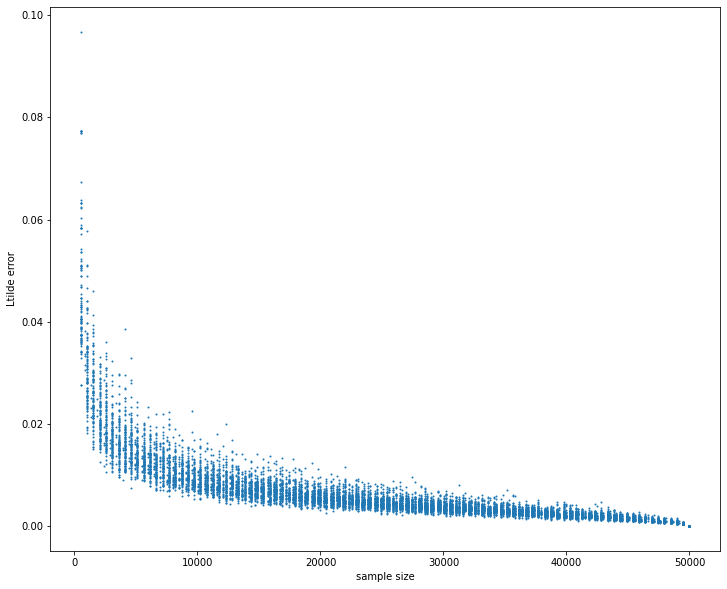

In [80]:
plt.rcParams['figure.figsize'] = (12,10)
plt.scatter(clado_sizes,Ltilde_errors,s=1)
plt.xlabel('sample size')
plt.ylabel('Ltilde error')

Text(0, 0.5, 'Ltilde error')

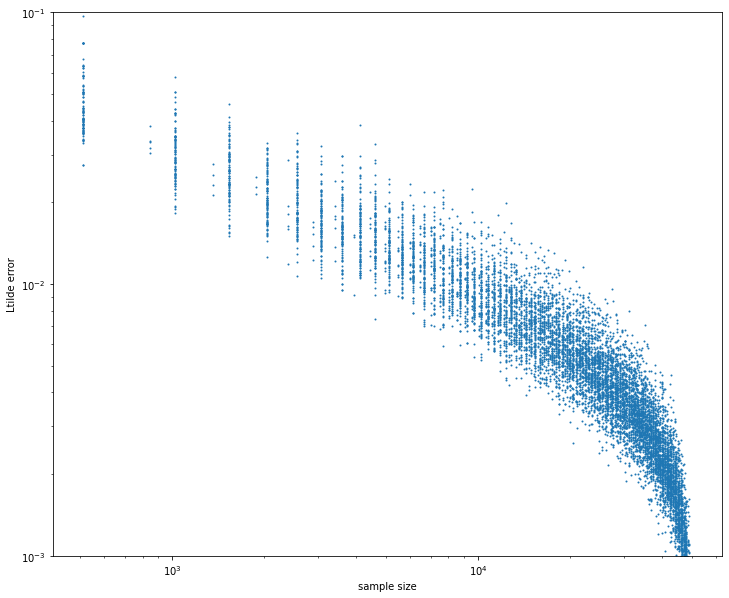

In [79]:
plt.rcParams['figure.figsize'] = (12,10)
plt.scatter(clado_sizes,Ltilde_errors,s=1)
plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-3,1e-1])
plt.xlabel('sample size')
plt.ylabel('Ltilde error')

In [77]:
def calculate_mean(size_arr,err_arr):
    size_err = {}
    
    for i in range(len(size_arr)):
        if size_arr[i] not in size_err:
            size_err[size_arr[i]] = [err_arr[i],]
        else:
            size_err[size_arr[i]].append(err_arr[i])
    
    size_arr_,err_arr_ = [],[]
    
    for size in size_err:
        size_err[size] = np.array(size_err[size])
        #size_err[size] = (size_err[size].mean(),size_err[size].std())
        
        size_arr_.append(size)
        err_arr_.append(size_err[size].mean())
    
    return size_arr_,err_arr_
clado_sizes_mean,clado_err_mean = calculate_mean(clado_sizes,Ltilde_errors)

Text(0, 0.5, 'Ltilde error')

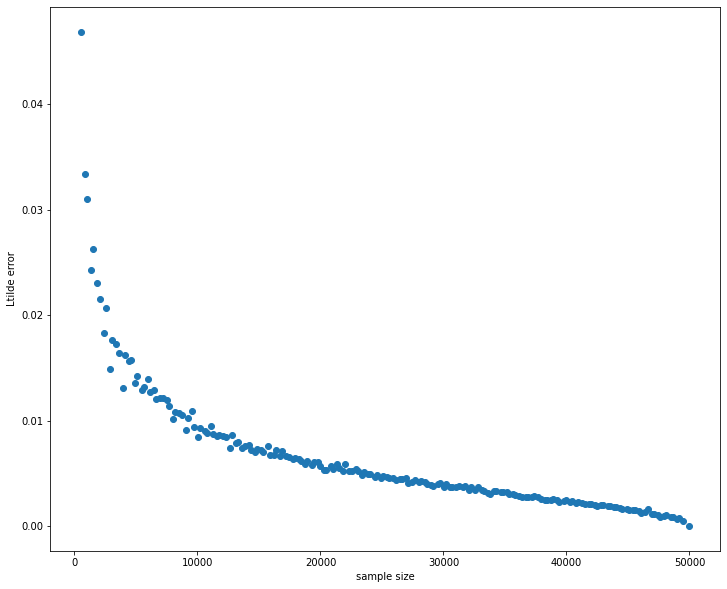

In [81]:
plt.scatter(clado_sizes_mean,clado_err_mean)
plt.xlabel('sample size')
plt.ylabel('Ltilde error')

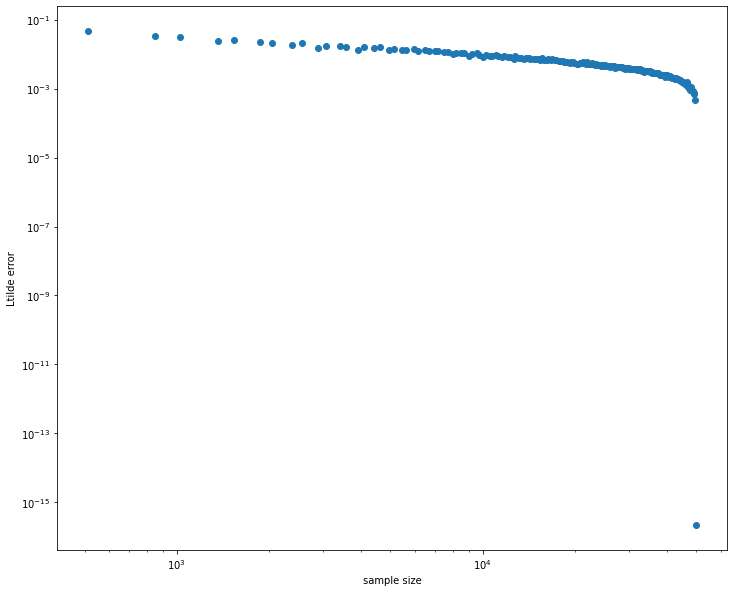

In [82]:
plt.scatter(clado_sizes_mean,clado_err_mean)
plt.xlabel('sample size')
plt.ylabel('Ltilde error')
plt.yscale('log')
plt.xscale('log')

(0.001, 0.1)

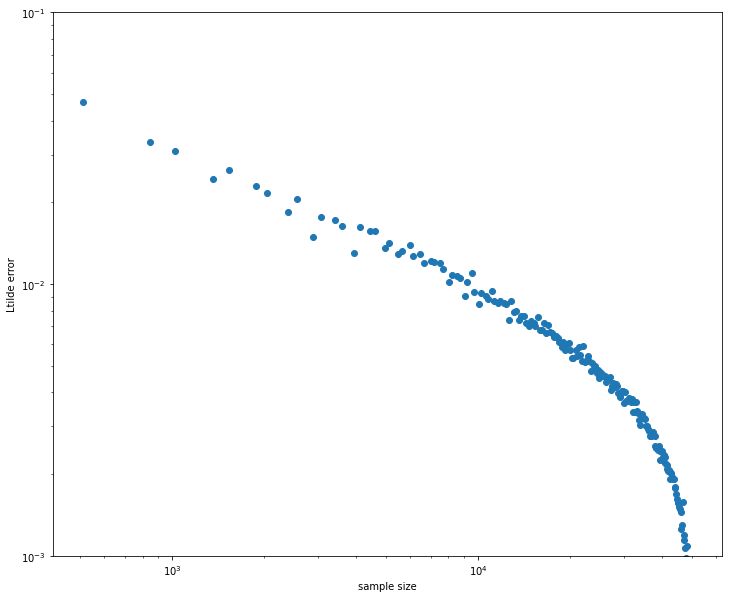

In [83]:
plt.scatter(clado_sizes_mean,clado_err_mean)
plt.xlabel('sample size')
plt.ylabel('Ltilde error')
plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-3,1e-1])

In [84]:
class layer_hook(object):

    def __init__(self):
        super(layer_hook, self).__init__()
        self.in_shape = None
        self.out_shape = None

    def hook(self, module, inp, outp):
        self.in_shape = inp[0].size()
        self.out_shape = outp.size()
    

hooks = {}

for layer in ref_layer_index:
    m = getModuleByName(model,layer[:-10])
    hook = layer_hook()
    hooks[layer[:-10]] = (hook,m.register_forward_hook(hook.hook))

In [85]:
with torch.no_grad():
    for img,label in train:
        model(img.cuda())
        break

In [86]:
def get_layer_bitops(layer_name,a_bits,w_bits):
    
    m = getModuleByName(model,layer_name)
    
    if isinstance(m,torch.nn.Conv2d):
        _,cin,_,_ = hooks[layer_name][0].in_shape
        _,cout,hout,wout = hooks[layer_name][0].out_shape
        
        n_muls = cin * m.weight.size()[2] * m.weight.size()[3] * cout * hout * wout
        n_accs = (cin * m.weight.size()[2] * m.weight.size()[3] - 1) * cout * hout * wout
        
        #bitops_per_mul = 2 * a_bits * w_bits
        #bitops_per_acc = (a_bits + w_bits) + np.ceil(np.log2(cin * m.weight.size()[2] * m.weight.size()[3]))
        
        bitops_per_mul = 5*a_bits*w_bits - 5*a_bits-3*w_bits+3
        bitops_per_acc = 3*a_bits + 3*w_bits + 29
        
        return n_muls * bitops_per_mul + n_accs * bitops_per_acc

In [87]:
index2layerscheme

[('layer1.0.conv1', '(8, 2)bits'),
 ('layer1.0.conv1', '(8, 4)bits'),
 ('layer1.0.conv1', '(8, 8)bits'),
 ('layer1.0.conv2', '(8, 2)bits'),
 ('layer1.0.conv2', '(8, 4)bits'),
 ('layer1.0.conv2', '(8, 8)bits'),
 ('layer1.1.conv1', '(8, 2)bits'),
 ('layer1.1.conv1', '(8, 4)bits'),
 ('layer1.1.conv1', '(8, 8)bits'),
 ('layer1.1.conv2', '(8, 2)bits'),
 ('layer1.1.conv2', '(8, 4)bits'),
 ('layer1.1.conv2', '(8, 8)bits'),
 ('layer1.2.conv1', '(8, 2)bits'),
 ('layer1.2.conv1', '(8, 4)bits'),
 ('layer1.2.conv1', '(8, 8)bits'),
 ('layer1.2.conv2', '(8, 2)bits'),
 ('layer1.2.conv2', '(8, 4)bits'),
 ('layer1.2.conv2', '(8, 8)bits'),
 ('layer2.0.conv1', '(8, 2)bits'),
 ('layer2.0.conv1', '(8, 4)bits'),
 ('layer2.0.conv1', '(8, 8)bits'),
 ('layer2.0.conv2', '(8, 2)bits'),
 ('layer2.0.conv2', '(8, 4)bits'),
 ('layer2.0.conv2', '(8, 8)bits'),
 ('layer2.0.downsample.0', '(8, 2)bits'),
 ('layer2.0.downsample.0', '(8, 4)bits'),
 ('layer2.0.downsample.0', '(8, 8)bits'),
 ('layer2.1.conv1', '(8, 2)bits'),

In [89]:
layer_size = np.array([0 for i in range(L)])
layer_bitops = np.array([0 for i in range(L)])
for l in ref_layer_index:
    index = ref_layer_index[l]
    layer_name, scheme = index2layerscheme[index]
    a_bits,w_bits = eval(scheme[:-4])
    #print(layer_name,a_bits,w_bits)
    layer_size[index] = torch.numel(getModuleByName(model,layer_name).weight) * int(w_bits)
    layer_bitops[index] = get_layer_bitops(layer_name,a_bits,w_bits)

In [91]:
def evaluate_decision(v,printInfo=False,test=test):
    global mqb_mix_model
    v = v.detach()
    # alpha = torch.nn.Softmax(dim=1)(v.reshape(-1,len(MPQ_scheme)))
    offset = torch.ones(int(L/len(aw_scheme)),dtype=int) * len(aw_scheme)
    offset = offset.cumsum(dim=-1) - len(aw_scheme)
    select = v.reshape(-1,len(aw_scheme)).argmax(dim=1) + offset
    
    modelsize = (layer_size[select]).sum()/8/1024/1024
    bitops = (layer_bitops[select]).sum()/10**9
    
    decisions = {}
    for scheme_id in select.numpy():
        layer,scheme = index2layerscheme[scheme_id]
        decisions[layer] = eval(scheme[:-4])
    
    print("evaluate_decision\n",decisions)
    

    with torch.no_grad():
        
        # perturb layers
        perturb(decisions)
            
        # do evaluation
        res = evaluate(test,mqb_mix_model)
        
        # recover layers
        mqb_mix_model = deepcopy(mqb_fp_model)
    return res,modelsize,bitops

In [100]:
import cvxpy as cp

def MIQCP_optimize(cached_grad,layer_bitops,layer_size,
                   schemes_per_layer=3,
                   bitops_bound=np.inf,size_bound=np.inf,
                   naive=False,PSD=True):
    
    if cached_grad.__class__ == torch.Tensor:
        cached_grad = cached_grad.cpu().numpy()
    
    
    x = cp.Variable(cached_grad.shape[0], boolean=True)
    schemes_per_layer = schemes_per_layer
    assert cached_grad.shape[0]%schemes_per_layer == 0, 'cached_gradient shape[0] does not divde schemes per layer'
    num_layers = cached_grad.shape[0]//schemes_per_layer
    
    if not naive:
        # convexation of cached_grad
        es,us = np.linalg.eig(cached_grad)
        if PSD:
            es[es<0] = 0
        C = us@np.diag(es)@us.T
        C = cp.atoms.affine.wraps.psd_wrap(C)
        objective = cp.Minimize(cp.quad_form(x,C))
    else:
        objective = cp.Minimize(np.diagonal(cached_grad)@x)

    equality_constraint_matrix = []
    for i in range(num_layers):
        col = np.zeros(cached_grad.shape[0])
        col[i*schemes_per_layer:(i+1)*schemes_per_layer] = 1
        equality_constraint_matrix.append(col)

    equality_constraint_matrix = np.array(equality_constraint_matrix)

    constraints = [equality_constraint_matrix@x == np.ones((num_layers,)),
                   layer_bitops@x/10**9<=bitops_bound,
                   layer_size@x/8/1024/1024<=size_bound]

    prob = cp.Problem(objective,constraints)
    prob.solve(verbose=False,
               TimeLimit=10,solver='GUROBI')
    
    # Print result.
    print(prob.status)
    print("\nThe optimal value is", prob.value)
    print("A solution x is")
    print(x.value)
    #print(f"bitops: {x.value@layer_bitops}")
    return x

In [122]:
cached_grad = np.zeros_like(true_Ltilde)
for i in range(cached_grad.shape[0]):
    for j in range(cached_grad.shape[0]):
        layer_i,scheme_i = ref_index2layerscheme[i]
        layer_j,scheme_j = ref_index2layerscheme[j]
        if layer_i == layer_j:
            if scheme_i == scheme_j:
                cached_grad[i,j] = cached_grad[j,i] = 2 * true_Ltilde[i,j]
            else:
                cached_grad[i,j] = cached_grad[j,i] = 0
        else:
            cached_grad[i,j] = cached_grad[j,i] = true_Ltilde[i,j] - true_Ltilde[i,i] - true_Ltilde[j,j]

v = MIQCP_optimize(cached_grad=cached_grad,
                   layer_bitops=layer_bitops,
                   layer_size=layer_size,
                   schemes_per_layer=len(aw_scheme),
                   bitops_bound=np.inf,size_bound=np.inf,
                   naive=True,PSD=True)
v = torch.Tensor(v.value)
evaluate_decision(v)

optimal

The optimal value is -0.017151323394775403
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 8), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}


({'top1': tensor([67.9700], device='cuda:0'),
  'top5': tensor([90.7000], device='cuda:0'),
  'loss': tensor(1.2527, device='cuda:0'),
  'time': 1.513390064239502},
 0.255126953125,
 13.36154112)

In [121]:
v = MIQCP_optimize(cached_grad=cached_grad,
                   layer_bitops=layer_bitops,
                   layer_size=layer_size,
                   schemes_per_layer=len(aw_scheme),
                   bitops_bound=np.inf,size_bound=np.inf,
                   naive=False,PSD=True)
v = torch.Tensor(v.value)
evaluate_decision(v)

optimal

The optimal value is 0.053435113917378665
A solution x is
[-0.  0.  1.  0. -0.  1. -0.  0.  1.  0.  0.  1. -0.  0.  1. -0.  1.  0.
  0. -0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0. -0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 8), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}


({'top1': tensor([68.5700], device='cuda:0'),
  'top5': tensor([90.8700], device='cuda:0'),
  'loss': tensor(1.2353, device='cuda:0'),
  'time': 1.4982895851135254},
 0.2562255859375,
 13.172895744)

In [ ]:
# 'layer2.0.conv1' is the one where linear objective fails



In [125]:
for n_batches in (1,2,4,8,16,32,64):
    
    for sid in range(5):
        
        print(f'{n_batches} batches, sid {sid}')
    
        shuffle = np.random.choice(98,n_batches,replace=False)

        new_batch_size = batch_size[shuffle]

        new_batch_Ltildes = batch_Ltildes[shuffle]

        est_Ltilde = np.einsum('a,abc->bc',new_batch_size,new_batch_Ltildes)

        n_samples = new_batch_size.sum()

        est_Ltilde /= n_samples

        diff = np.abs(est_Ltilde - true_Ltilde).mean()
        
        # calculate est ltilde
        
        cached_grad = np.zeros_like(est_Ltilde)
        
        for i in range(cached_grad.shape[0]):
            for j in range(cached_grad.shape[0]):
                layer_i,scheme_i = ref_index2layerscheme[i]
                layer_j,scheme_j = ref_index2layerscheme[j]
                if layer_i == layer_j:
                    if scheme_i == scheme_j:
                        cached_grad[i,j] = cached_grad[j,i] = 2 * est_Ltilde[i,j]
                    else:
                        cached_grad[i,j] = cached_grad[j,i] = 0
                else:
                    cached_grad[i,j] = cached_grad[j,i] = est_Ltilde[i,j] - est_Ltilde[i,i] - est_Ltilde[j,j]
        
        
        res = {}
        
        res['batches'] = shuffle
        res['est_Ltilde'] = est_Ltilde
        res['n_samples'] = n_samples
        res['Ltilde_error'] = diff
        res['clado_perf'],res['clado_size'] = [],[]
        res['naive_perf'],res['naive_size'] = [],[]
        
        for size_bound in np.linspace(0.125,0.2563,100):
            
            print(f'size bound {size_bound:.4f}MB')
            v = MIQCP_optimize(cached_grad=cached_grad,
                   layer_bitops=layer_bitops,
                   layer_size=layer_size,
                   schemes_per_layer=len(aw_scheme),
                   bitops_bound=np.inf,size_bound=size_bound,
                   naive=False,PSD=True)
            v = torch.Tensor(v.value)
            
            perf,size,bitops = evaluate_decision(v)
            
            res['clado_perf'].append(perf)
            res['clado_size'].append(size)
            
            v = MIQCP_optimize(cached_grad=cached_grad,
                   layer_bitops=layer_bitops,
                   layer_size=layer_size,
                   schemes_per_layer=len(aw_scheme),
                   bitops_bound=np.inf,size_bound=size_bound,
                   naive=True,PSD=True)
            v = torch.Tensor(v.value)
            
            perf,size,bitops = evaluate_decision(v)
            
            res['naive_perf'].append(perf)
            res['naive_size'].append(size)
        
        with open(f'{n_batches}batches_sid{sid}.pkl','wb') as f:
            pickle.dump(res,f)
        
        
    
    
    

1 batches, sid 0
size bound 0.1250MB
optimal

The optimal value is 3.2237558716673003
A solution x is
[-0.  1.  0.  0.  1. -0. -0.  1. -0.  0.  1.  0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 4), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
optimal

The optimal value is 2.2912161350250244
A solution x is
[-0.  1.  0. -0.  1.  0. -0.  1.  

size bound 0.1316MB
optimal

The optimal value is 2.4967599487819325
A solution x is
[-0.  1.  0. -0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  1.  0. -0.  1. -0.
 -0. -0.  1. -0. -0.  1.  0. -0.  1. -0.  1.  0.  0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1. -0.
 -0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
optimal

The optimal value is 1.7622687816619873
A solution x is
[ 0.  1.  0.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0

size bound 0.1383MB
optimal

The optimal value is 1.8362306425174326
A solution x is
[-0.  1.  0. -0.  1.  0. -0.  0.  1. -0.  1.  0. -0.  1.  0. -0.  1.  0.
 -0. -0.  1. -0.  1. -0. -0.  0.  1. -0.  1.  0. -0.  1.  0. -0. -0.  1.
 -0.  1.  0. -0.  1.  0. -0.  1. -0. -0. -0.  1. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 4), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 1.1980676651000977
A solution x is
[-0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0

size bound 0.1449MB
optimal

The optimal value is 1.1330502381833347
A solution x is
[-0.  1.  0. -0.  1.  0. -0. -0.  1. -0.  1.  0. -0.  1.  0. -0.  1. -0.
  0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.  0. -0.  1.
  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  0.  1.  0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.8400545120239258
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

size bound 0.1515MB
optimal

The optimal value is 0.803717840534982
A solution x is
[-0.  0.  1.  0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  1.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  0.  1.
  0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  0.  1. -0.  1.  0. -0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.7077579498291016
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.

size bound 0.1582MB
optimal

The optimal value is 0.7344212953000036
A solution x is
[-0.  1.  0. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  1.  0. -0.  1.  0.
  0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0.  0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.523794412612915
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.

size bound 0.1648MB
optimal

The optimal value is 0.6349371355514688
A solution x is
[-0.  1.  0. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0. -0.  1.  0.
 -0.  1.  0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.4712028503417969
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

size bound 0.1714MB
optimal

The optimal value is 0.5637850537423899
A solution x is
[-0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  0.  1. -0.  0.  1. -0.  1.  0. -0. -0.  1. -0.  1.  0. -0.  1.  0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.43373537063598633
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

size bound 0.1781MB
optimal

The optimal value is 0.49878280782966467
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.
  0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0.  1. -0. -0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.3488430976867676
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

size bound 0.1847MB
optimal

The optimal value is 0.426448235686862
A solution x is
[ 0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1. -0.  1. -0. -0. -0.  1.  0. -0.  1.  0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.25878405570983887
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

size bound 0.1913MB
optimal

The optimal value is 0.35666336898749185
A solution x is
[ 0.  0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  0.  1. -0.  1. -0.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.
  0.  1. -0.  0.  1.  0. -0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.25878405570983887
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

size bound 0.1979MB
optimal

The optimal value is 0.2738004146014629
A solution x is
[ 0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0. -0. -0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1.  0.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  0.  1.  0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.14608311653137207
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

size bound 0.2046MB
optimal

The optimal value is 0.20584350876210894
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  1.  0. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.10861563682556152
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

size bound 0.2112MB
optimal

The optimal value is 0.20584350876210894
A solution x is
[ 0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.
  0. -0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
 -0.  1. -0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.10861563682556152
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

size bound 0.2178MB
optimal

The optimal value is 0.15731985968768963
A solution x is
[ 0.  1. -0.  0. -0.  1.  0.  0.  1.  0. -0.  1.  0.  1.  0. -0. -0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1. -0.
 -0. -0.  1.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.0807807445526123
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

size bound 0.2245MB
optimal

The optimal value is 0.13135044927411005
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.04331326484680176
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 

size bound 0.2311MB
optimal

The optimal value is 0.13135044927411005
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.04331326484680176
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 

size bound 0.2377MB
optimal

The optimal value is 0.11605528294146819
A solution x is
[0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
optimal

The optimal value is 0.0009641647338867188
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1

size bound 0.2444MB
optimal

The optimal value is 0.09018350990101758
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  1.  0.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
optimal

The optimal value is 0.0009641647338867188
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1

size bound 0.2510MB
optimal

The optimal value is 0.09018350990101758
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
optimal

The optimal value is 0.0009641647338867188
A solution x is
[ 0. -0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1

1 batches, sid 1
size bound 0.1250MB
optimal

The optimal value is 2.957834458696199
A solution x is
[-0.  1.  0.  0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1. -0.
 -0.  1.  0. -0.  0.  1. -0. -0.  1. -0.  1.  0. -0.  1.  0.  0.  1. -0.
  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1. -0.
 -0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 4), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
optimal

The optimal value is 2.2794926166534424
A solution x is
[-0.  1. -0. -0.  1.  0. -0.  1.  0

size bound 0.1316MB
optimal

The optimal value is 2.184250453670483
A solution x is
[-0.  1. -0. -0. -0.  1. -0.  1.  0. -0.  0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
  0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
optimal

The optimal value is 1.7162907123565674
A solution x is
[-0.  1.  0. -0.  1.  0. -0.  1.  0. -0. -0.  1. -0.

size bound 0.1383MB
optimal

The optimal value is 1.8232459182499146
A solution x is
[-0.  1.  0.  0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1. -0.
  0.  1. -0. -0. -0.  1. -0.  0.  1. -0.  1. -0.  0.  1. -0. -0.  0.  1.
  0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 1.3407366275787354
A solution x is
[0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1.

size bound 0.1449MB
optimal

The optimal value is 1.2223796787206307
A solution x is
[-0.  1.  0. -0. -0.  1. -0.  1.  0. -0.  0.  1. -0.  1.  0.  0.  1. -0.
 -0.  1.  0. -0. -0.  1. -0.  0.  1. -0. -0.  1.  0.  1. -0. -0.  0.  1.
 -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.9500045776367188
A solution x is
[-0.  1.  0. -0.  1.  0. -0.  1.  0. -0. -0.  1. -0

size bound 0.1515MB
optimal

The optimal value is 0.9220729941331777
A solution x is
[-0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  1. -0.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  1.  0. -0. -0.  1.
 -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  0.  1. -0.  1.  0. -0.  1.  0.
 -0.  1. -0. -0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.7168364524841309
A solution x is
[-0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

size bound 0.1582MB
optimal

The optimal value is 0.7297603168689258
A solution x is
[-0. -0.  1.  0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  1. -0.
  0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0.  0.  1. -0.
 -0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.5120751857757568
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

size bound 0.1648MB
optimal

The optimal value is 0.5988433895111991
A solution x is
[ 0. -0.  1.  0.  0.  1.  0. -0.  1. -0. -0.  1.  0.  0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0.  0.  1.  0.  0.  1. -0.  1.  0.  0.  0.  1.
  0.  0.  1.  0.  0.  1. -0.  1. -0. -0.  0.  1. -0.  1. -0.  0.  1.  0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.4533395767211914
A solution x is
[0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1.

size bound 0.1714MB
optimal

The optimal value is 0.54591773192228
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1.  0.  0.  1. -0.  0.  1. -0. -0.  1.
 -0.  0.  1.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.4243497848510742
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. 

size bound 0.1781MB
optimal

The optimal value is 0.49829473388062373
A solution x is
[ 0. -0.  1.  0.  0.  1.  0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1. -0.  1.  0. -0. -0.  1. -0.  0.  1.  0.  1.  0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.32743120193481445
A solution x is
[ 0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1. 

size bound 0.1847MB
optimal

The optimal value is 0.4123713201981483
A solution x is
[ 0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0. -0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1. -0.  1.  0.  0.  0.  1. -0.  0.  1.  0.  1.  0.
 -0.  1.  0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.2611806392669678
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1.

size bound 0.1913MB
optimal

The optimal value is 0.36930242657280665
A solution x is
[-0. -0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1. -0.  1.  0.  0. -0.  1. -0.  0.  1. -0.  1. -0.
 -0.  1.  0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.22552037239074707
A solution x is
[ 0.  1.  0.  0. -0.  1.  0. -0.  1.  0.  0.  1. 

size bound 0.1979MB
optimal

The optimal value is 0.29118558110958115
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  1.  0.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.14687848091125488
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

size bound 0.2046MB
optimal

The optimal value is 0.21440033809108777
A solution x is
[-0. -0.  1.  0. -0.  1. -0.  0.  1.  0.  0.  1. -0.  0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.
  0. -0.  1.  0.  0.  1.  0.  0.  1. -0.  0.  1. -0. -0.  1.  0.  1.  0.
 -0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.10907602310180664
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

size bound 0.2112MB
optimal

The optimal value is 0.20229327200579472
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  1.  0.
  0.  1.  0. -0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.10907602310180664
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 

size bound 0.2178MB
optimal

The optimal value is 0.16951633179155826
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1. -0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.0288238525390625
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

size bound 0.2245MB
optimal

The optimal value is 0.12380907732243401
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.02637195587158203
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

size bound 0.2311MB
optimal

The optimal value is 0.12380907732243401
A solution x is
[-0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.02637195587158203
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

size bound 0.2377MB
optimal

The optimal value is 0.12380907732243401
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.0076100826263427734
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0

size bound 0.2444MB
optimal

The optimal value is 0.10757135320433697
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
optimal

The optimal value is 0.0076100826263427734
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1

size bound 0.2510MB
optimal

The optimal value is 0.10757135320433697
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
optimal

The optimal value is 0.0076100826263427734
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0

1 batches, sid 2
size bound 0.1250MB
optimal

The optimal value is 3.02830953175613
A solution x is
[-0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1. -0.
 -0.  1.  0. -0.  0.  1. -0.  0.  1. -0.  1.  0.  0.  1. -0.  0.  1.  0.
  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  0.  1. -0.
 -0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 4), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
optimal

The optimal value is 2.459077835083008
A solution x is
[-0.  1.  0. -0.  1.  0. -0.  1.  0. 

size bound 0.1316MB
optimal

The optimal value is 2.4156785128038276
A solution x is
[ 0.  1.  0. -0.  0.  1. -0.  1.  0. -0.  1.  0. -0.  0.  1. -0.  1. -0.
 -0.  1.  0.  0. -0.  1. -0.  0.  1. -0.  1.  0.  0.  1. -0. -0. -0.  1.
  0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1. -0.
  0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
optimal

The optimal value is 1.8729839324951172
A solution x is
[-0.  1. -0. -0.  1. -0. -0. -0.  1. -0.  1.  0. -0

size bound 0.1383MB
optimal

The optimal value is 1.894205887158675
A solution x is
[-0.  0.  1. -0. -0.  1. -0.  1.  0. -0.  1.  0. -0. -0.  1. -0.  1. -0.
 -0.  1. -0. -0.  1.  0. -0.  0.  1. -0.  1.  0.  0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0.  1.  0. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 4), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 1.3811595439910889
A solution x is
[-0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.

size bound 0.1449MB
optimal

The optimal value is 1.1627214744470986
A solution x is
[-0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1. -0. -0.  0.  1. -0. -0.  1. -0.  1.  0. -0.  1.  0. -0.  0.  1.
  0.  1.  0. -0.  1.  0. -0.  1.  0. -0. -0.  1. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.964505672454834
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.

size bound 0.1515MB
optimal

The optimal value is 0.7714492925966364
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  0.  1.
 -0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.7587499618530273
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

size bound 0.1582MB
optimal

The optimal value is 0.712286885184652
A solution x is
[ 0. -0.  1.  0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  1.  0.
 -0.  0.  1.  0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  1.  0. -0.  0.  1.
  0.  0.  1. -0.  1.  0.  0.  1.  0. -0.  0.  1. -0.  1.  0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.5522916316986084
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.

size bound 0.1648MB
optimal

The optimal value is 0.6380201248215819
A solution x is
[-0. -0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0. -0.  1.  0.  0.  1. -0.  1.  0. -0. -0.  1.  0.  1. -0.  0.  1.  0.
 -0.  1.  0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.47757816314697266
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

size bound 0.1714MB
optimal

The optimal value is 0.5802670686506712
A solution x is
[-0. -0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0.  1.  0. -0.  1.  0. -0. -0.  1.  0.  0.  1.  0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.4490525722503662
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

size bound 0.1781MB
optimal

The optimal value is 0.4866024192308989
A solution x is
[-0.  1.  0.  0. -0.  1.  0.  0.  1. -0.  0.  1.  0.  1.  0. -0.  1.  0.
  0.  1. -0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1. -0.  1.  0.  0.  0.  1.  0. -0.  1.  0.  1. -0.
 -0.  1.  0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.386441707611084
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.

size bound 0.1847MB
optimal

The optimal value is 0.39317195582286907
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1.
  0. -0.  1. -0. -0.  1.  0.  0.  1.  0. -0.  1.  0.  1.  0. -0.  0.  1.
 -0.  0.  1.  0.  0.  1.  0.  1.  0. -0.  0.  1.  0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.31100988388061523
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

size bound 0.1913MB
optimal

The optimal value is 0.38578850755096183
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  0.  1. -0.  1. -0.
 -0.  1. -0. -0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.2971062660217285
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

size bound 0.1979MB
optimal

The optimal value is 0.28975932580404906
A solution x is
[-0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1. -0.  1.  0.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  1.  0.  0.  0.  1.
  0.  0.  1.  0.  0.  1. -0.  0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
 -0.  1.  0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.20895910263061523
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

size bound 0.2046MB
optimal

The optimal value is 0.24759192449538836
A solution x is
[ 0.  0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.16652989387512207
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

size bound 0.2112MB
optimal

The optimal value is 0.2301208264110495
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  1. -0.
 -0.  1.  0. -0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.16007447242736816
A solution x is
[ 0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  

size bound 0.2178MB
optimal

The optimal value is 0.16011089984210888
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0.  0.  1. -0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.09926462173461914
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 

size bound 0.2245MB
optimal

The optimal value is 0.1412834131352114
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0.  0.  1. -0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.0707390308380127
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.

size bound 0.2311MB
optimal

The optimal value is 0.1412834131352114
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.0707390308380127
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.

size bound 0.2377MB
optimal

The optimal value is 0.11047404774371623
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0. -0.  1. -0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
optimal

The optimal value is 0.030086040496826172
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.

size bound 0.2444MB
optimal

The optimal value is 0.08824658583598045
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0. -0.  1. -0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
optimal

The optimal value is 0.030086040496826172
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.

size bound 0.2510MB
optimal

The optimal value is 0.08824658583598045
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0. -0.  1. -0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
optimal

The optimal value is 0.030086040496826172
A solution x is
[ 0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.

1 batches, sid 3
size bound 0.1250MB
optimal

The optimal value is 2.4874937565385395
A solution x is
[-0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0. -0.  1.  0.  0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 4), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
optimal

The optimal value is 2.236696243286133
A solution x is
[-0.  1.  0. -0.  1.  0. -0.  1.  0

size bound 0.1316MB
optimal

The optimal value is 2.053265867082494
A solution x is
[-0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  0.  1. -0.  1.  0. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1.  0. -0. -0.  1.
  0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1. -0.
 -0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
optimal

The optimal value is 1.7405660152435303
A solution x is
[-0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.

size bound 0.1383MB
optimal

The optimal value is 1.5743819458720811
A solution x is
[-0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.
  0.  1. -0. -0. -0.  1. -0.  1.  0. -0.  1. -0.  0.  1. -0. -0. -0.  1.
  0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 4), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 1.2680156230926514
A solution x is
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.

size bound 0.1449MB
optimal

The optimal value is 1.1067914074129919
A solution x is
[-0.  1.  0. -0. -0.  1. -0.  1.  0. -0.  0.  1. -0.  1.  0. -0.  1.  0.
 -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0. -0. -0.  1.
 -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.9216728210449219
A solution x is
[-0.  0.  1. -0.  1. -0. -0.  1.  0. -0.  1. -0. -0

size bound 0.1515MB
optimal

The optimal value is 0.8319756454897886
A solution x is
[-0.  0.  1.  0. -0.  1. -0.  1.  0. -0.  0.  1. -0.  0.  1. -0.  0.  1.
  0.  0.  1. -0.  0.  1. -0.  0.  1.  0.  0.  1. -0.  1.  0. -0.  0.  1.
  0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  0.  1. -0.  1.  0.  0.  1.  0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.6632180213928223
A solution x is
[-0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0. -0

size bound 0.1582MB
optimal

The optimal value is 0.7186744658964094
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  1.  0. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.4303462505340576
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

size bound 0.1648MB
optimal

The optimal value is 0.5939904920855799
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.  0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.4053764343261719
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

size bound 0.1714MB
optimal

The optimal value is 0.5324186801076767
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  0.  1. -0.  1.  0. -0.  1. -0.
  0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.3829314708709717
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

size bound 0.1781MB
optimal

The optimal value is 0.4593681549552603
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.  0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  1.  0.  0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.2475605010986328
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

size bound 0.1847MB
optimal

The optimal value is 0.359299564268133
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1.  0.  0.  1. -0.  0.  1. -0.  1.  0. -0.  1.  0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.20014572143554688
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

size bound 0.1913MB
optimal

The optimal value is 0.33229578122923803
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1.  0.
 -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.15378046035766602
A solution x is
[ 0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0. 

size bound 0.1979MB
optimal

The optimal value is 0.23137464239756447
A solution x is
[-0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.06335783004760742
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

size bound 0.2046MB
optimal

The optimal value is 0.18321259163996065
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1.
 -0. -0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.04091286659240723
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

size bound 0.2112MB
optimal

The optimal value is 0.1554917479282463
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.04091286659240723
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  

size bound 0.2178MB
optimal

The optimal value is 0.11504250867198203
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.027604103088378906
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.

size bound 0.2245MB
optimal

The optimal value is 0.09000120062279529
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.005159139633178711
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.

size bound 0.2311MB
optimal

The optimal value is 0.09000120062279529
A solution x is
[-0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0. -0.  1. -0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.005159139633178711
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.

size bound 0.2377MB
optimal

The optimal value is 0.09000120062279529
A solution x is
[-0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0. -0.  1.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is -0.007475852966308594
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0

size bound 0.2444MB
optimal

The optimal value is 0.07191761203610966
A solution x is
[-0.  0.  1.  0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1.
 -0.  0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1.  0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 8), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is -0.007475852966308594
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1

size bound 0.2510MB
optimal

The optimal value is 0.07191761203610966
A solution x is
[-0.  0.  1.  0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1.
 -0.  0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1.  0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 8), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is -0.007475852966308594
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0

1 batches, sid 4
size bound 0.1250MB
optimal

The optimal value is 3.1588655306229034
A solution x is
[-0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1.  0. -0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  0.  1.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 4), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
optimal

The optimal value is 2.3590879440307617
A solution x is
[-0.  1. -0. -0.  1.  0. -0.  1.  

size bound 0.1316MB
optimal

The optimal value is 2.3357035849410206
A solution x is
[-0.  1. -0. -0.  1.  0. -0. -0.  1. -0.  0.  1. -0.  1.  0.  0.  1. -0.
 -0.  1. -0. -0. -0.  1. -0. -0.  1. -0.  1.  0.  0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1. -0.
 -0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
optimal

The optimal value is 1.7196855545043945
A solution x is
[-0.  1. -0. -0.  1.  0. -0.  1.  0. -0. -0.  1. -0

size bound 0.1383MB
optimal

The optimal value is 1.7491355092997496
A solution x is
[-0.  1.  0. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  1.  0. -0.  1.  0.
 -0.  1.  0. -0.  1.  0. -0.  0.  1. -0.  1.  0. -0.  1.  0. -0. -0.  1.
 -0.  1. -0. -0.  1.  0. -0.  1. -0. -0. -0.  1. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 4), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 1.1846253871917725
A solution x is
[-0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

size bound 0.1449MB
optimal

The optimal value is 1.0947446536515844
A solution x is
[-0.  1. -0. -0.  0.  1. -0.  1.  0. -0. -0.  1. -0.  1. -0. -0.  1.  0.
 -0.  1. -0. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.7875118255615234
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

size bound 0.1515MB
optimal

The optimal value is 0.8334529538979375
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  1. -0.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0.  1.  0. -0.  1. -0. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.5697782039642334
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

size bound 0.1582MB
optimal

The optimal value is 0.7361047414284906
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1. -0.  1.  0.
 -0.  1.  0. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  1.  0. -0.  0.  1.
  0.  1. -0. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.4136641025543213
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

size bound 0.1648MB
optimal

The optimal value is 0.6041682596480937
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
  0.  0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  1.  0. -0.  1. -0.
 -0.  1.  0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.3731520175933838
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

size bound 0.1714MB
optimal

The optimal value is 0.569149478742455
A solution x is
[ 0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1.  0.  1.  0. -0. -0.  1. -0.  1.  0. -0.  1. -0.
 -0.  1.  0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.362255334854126
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. 

size bound 0.1781MB
optimal

The optimal value is 0.4724960513454358
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0.  1.  0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.27541089057922363
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

size bound 0.1847MB
optimal

The optimal value is 0.43384776824512106
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1.
 -0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1.  0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.22841691970825195
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

size bound 0.1913MB
optimal

The optimal value is 0.41925348231389664
A solution x is
[-0.  0.  1.  0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1. -0.  1.  0. -0.  0.  1.  0. -0.  1.  0.  1. -0.
 -0.  1.  0. -0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.1825263500213623
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

size bound 0.1979MB
optimal

The optimal value is 0.33226612113394116
A solution x is
[-0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0.  1. -0. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  1. -0. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.10591697692871094
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

size bound 0.2046MB
optimal

The optimal value is 0.29483600300314117
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  1. -0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.09502029418945312
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

size bound 0.2112MB
optimal

The optimal value is 0.2759330283854234
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0.  1. -0. -0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.05147838592529297
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

size bound 0.2178MB
optimal

The optimal value is 0.18340453373486668
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.010966300964355469
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.

size bound 0.2245MB
optimal

The optimal value is 0.17067455150396343
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0. -0.  1. -0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 6.961822509765625e-05
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1

size bound 0.2311MB
optimal

The optimal value is 0.17067455150396343
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0. -0.  1. -0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is -0.008450031280517578
A solution x is
[0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0

size bound 0.2377MB
optimal

The optimal value is 0.15004255730207502
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
optimal

The optimal value is -0.036333560943603516
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0

size bound 0.2444MB
optimal

The optimal value is 0.13044416284032187
A solution x is
[-0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1.  0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  1.  0.
  0. -0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
optimal

The optimal value is -0.036333560943603516
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0

size bound 0.2510MB
optimal

The optimal value is 0.13044416284032187
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
optimal

The optimal value is -0.036333560943603516
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0

2 batches, sid 0
size bound 0.1250MB
optimal

The optimal value is 2.742104029987216
A solution x is
[-0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.
  0.  1. -0. -0.  0.  1. -0. -0.  1. -0.  1.  0.  0.  1. -0. -0.  1.  0.
  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1. -0.
  0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 4), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
optimal

The optimal value is 2.193753957748413
A solution x is
[-0.  1. -0. -0.  1. -0. -0.  1.  0.

size bound 0.1316MB
optimal

The optimal value is 2.073063250169377
A solution x is
[-0.  1.  0. -0.  1.  0. -0.  0.  1. -0.  0.  1. -0.  1.  0. -0.  1.  0.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1.  0. -0. -0.  1.
  0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1. -0.
 -0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
optimal

The optimal value is 1.6075776815414429
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 

size bound 0.1383MB
optimal

The optimal value is 1.64076428050824
A solution x is
[-0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  0.  1. -0.
 -0.  1. -0. -0. -0.  1. -0. -0.  1. -0.  1.  0.  0.  1. -0. -0.  0.  1.
 -0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 1.0936497449874878
A solution x is
[-0.  1. -0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0. 

size bound 0.1449MB
optimal

The optimal value is 1.0211148692141305
A solution x is
[-0.  1.  0. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  1.  0. -0.  1.  0.
 -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0.  1.  0. -0.  1. -0.  0.  1. -0. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.7545264959335327
A solution x is
[-0.  1. -0. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0

size bound 0.1515MB
optimal

The optimal value is 0.7295215148304
A solution x is
[ 0.  0.  1.  0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  1.  0.
 -0.  0.  1. -0. -0.  1.  0.  0.  1. -0.  0.  1. -0.  1.  0. -0.  0.  1.
 -0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  0.  1. -0.  1.  0. -0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.632519006729126
A solution x is
[ 0.  0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0

size bound 0.1582MB
optimal

The optimal value is 0.6647252359112746
A solution x is
[-0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  1.  0. -0.  0.  1. -0.  0.  1.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  1. -0. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.43820106983184814
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

size bound 0.1648MB
optimal

The optimal value is 0.5652283880540049
A solution x is
[-0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  1.  0. -0.  1. -0.
 -0.  1.  0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.3942936658859253
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

size bound 0.1714MB
optimal

The optimal value is 0.538510873584927
A solution x is
[-0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1.
 -0.  0.  1. -0. -0.  1.  0.  0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1.
 -0.  0.  1. -0.  0.  1.  0.  1.  0. -0.  0.  1. -0.  1.  0. -0.  1. -0.
  0.  1.  0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.36224424839019775
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1.

size bound 0.1781MB
optimal

The optimal value is 0.4576743850457931
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  1.  0. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1.  0. -0. -0.  1. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.2550191879272461
A solution x is
[-0.  0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0

size bound 0.1847MB
optimal

The optimal value is 0.4123638346473524
A solution x is
[-0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  1. -0. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.19961869716644287
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

size bound 0.1913MB
optimal

The optimal value is 0.37889285825430324
A solution x is
[-0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  1.  0.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  1.  0.
 -0.  1. -0. -0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.1931377649307251
A solution x is
[-0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -

size bound 0.1979MB
optimal

The optimal value is 0.2879854621352306
A solution x is
[-0. -0.  1.  0.  0.  1. -0.  0.  1. -0.  1.  0. -0.  0.  1. -0.  0.  1.
  0.  1. -0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  0.  1.  0.  0.  1. -0. -0.  1. -0.  0.  1.  0.  0.  1.  0.  1.  0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.11625468730926514
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

size bound 0.2046MB
optimal

The optimal value is 0.2475349003672865
A solution x is
[ 0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1.  0.  0.  0.  1. -0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0. -0.  1.  0.  0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.09382987022399902
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

size bound 0.2112MB
optimal

The optimal value is 0.220847246304927
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1.
 -0.  1.  0. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.055000901222229004
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

size bound 0.2178MB
optimal

The optimal value is 0.1250880891508497
A solution x is
[-0.  0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0. -0.  1. -0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.00272524356842041
A solution x is
[-0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -

size bound 0.2245MB
optimal

The optimal value is 0.1143197189665071
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0. -0.  1.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is -0.011331319808959961
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.

size bound 0.2311MB
optimal

The optimal value is 0.1143197189665071
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is -0.017598748207092285
A solution x is
[-0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.

size bound 0.2377MB
optimal

The optimal value is 0.08595227520637631
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
optimal

The optimal value is -0.05408012866973877
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.

size bound 0.2444MB
optimal

The optimal value is 0.07047242603422357
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
optimal

The optimal value is -0.05408012866973877
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.

optimal

The optimal value is -0.05408012866973877
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2523MB
optimal

The optimal value is 0.07047242603422357
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.

optimal

The optimal value is 2.3254932165145874
A solution x is
[-0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1. -0.
  0.  1.  0.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1.  0.
  0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 4), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
size bound 0.1263MB
optimal

The optimal value is 2.409246067946511
A solution x is
[-0.  1. -0. -0.  1.  0. -0.  0.  1. -0.  1.  0. -0.

optimal

The optimal value is 1.780998706817627
A solution x is
[-0.  1. -0. -0.  1.  0. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1.  0.
  0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
size bound 0.1330MB
optimal

The optimal value is 1.8637222109802747
A solution x is
[-0.  1.  0. -0.  1.  0. -0.  0.  1. -0.  1.  0. -0.

optimal

The optimal value is 1.3148736953735352
A solution x is
[-0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1.  0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 4), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1396MB
optimal

The optimal value is 1.4720170546070461
A solution x is
[-0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0

optimal

The optimal value is 0.9321283102035522
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  0.  1.  0.  1. -0.  0.  1.  0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1462MB
optimal

The optimal value is 0.9400157447880557
A solution x is
[-0.  1. -0. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.7010287046432495
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0. -0.  1.  0.  0.  1. -0.  0.  1.  0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1529MB
optimal

The optimal value is 0.7689792660782603
A solution x is
[-0.  0.  1.  0.  0.  1. -0. -0.  1. -0.  0.  1. -0

optimal

The optimal value is 0.4751715660095215
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1595MB
optimal

The optimal value is 0.6343429734395826
A solution x is
[-0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0

optimal

The optimal value is 0.43569815158843994
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1661MB
optimal

The optimal value is 0.5620184069442912
A solution x is
[-0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.40982556343078613
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1727MB
optimal

The optimal value is 0.5207245396903122
A solution x is
[-0.  1.  0.  0.  0.  1. -0.  0.  1.  0.  0.  1.  

optimal

The optimal value is 0.28823328018188477
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1794MB
optimal

The optimal value is 0.4383979472765916
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.23263311386108398
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1860MB
optimal

The optimal value is 0.40487117813382323
A solution x is
[-0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. 

optimal

The optimal value is 0.20262205600738525
A solution x is
[-0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1. -0.  1.  0.  0. -0.  1.  0.  1.  0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1926MB
optimal

The optimal value is 0.3404096913395076
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.11419522762298584
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  1. -0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1993MB
optimal

The optimal value is 0.2629172246721995
A solution x is
[ 0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -

optimal

The optimal value is 0.08344972133636475
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.2059MB
optimal

The optimal value is 0.21736648630077465
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 

optimal

The optimal value is 0.05301868915557861
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2125MB
optimal

The optimal value is 0.20192029661070182
A solution x is
[-0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1. 

optimal

The optimal value is 0.018418192863464355
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2192MB
optimal

The optimal value is 0.1383832204226862
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is -0.007454395294189453
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2258MB
optimal

The optimal value is 0.11923259424693033
A solution x is
[-0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1

optimal

The optimal value is -0.007454395294189453
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2324MB
optimal

The optimal value is 0.11923259424693033
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1

optimal

The optimal value is -0.054530978202819824
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2391MB
optimal

The optimal value is 0.06747067756967041
A solution x is
[-0.  0.  1.  0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  1.  0.
 -0. -0.  1.  0. -0.  1. -0.  0.  1

optimal

The optimal value is -0.054530978202819824
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2457MB
optimal

The optimal value is 0.06747067756967041
A solution x is
[-0.  0.  1.  0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  1.  0.
 -0. -0.  1.  0. -0.  1. -0.  0.  1

optimal

The optimal value is -0.054530978202819824
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2523MB
optimal

The optimal value is 0.06747067756967041
A solution x is
[-0.  0.  1.  0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  1.  0.
 -0. -0.  1.  0. -0.  1. -0.  0.  1

optimal

The optimal value is 2.498743176460266
A solution x is
[-0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 4), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
size bound 0.1263MB
optimal

The optimal value is 2.7886363056048453
A solution x is
[ 0.  1. -0. -0.  0.  1. -0.  1.  0. -0.  1.  0. -0.

optimal

The optimal value is 1.9187164306640625
A solution x is
[-0.  1. -0. -0.  1.  0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
size bound 0.1330MB
optimal

The optimal value is 2.1662487426225825
A solution x is
[-0.  1. -0. -0. -0.  1. -0.  0.  1. -0.  1.  0. -0

optimal

The optimal value is 1.379247784614563
A solution x is
[-0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1396MB
optimal

The optimal value is 1.520865939886566
A solution x is
[-0.  1.  0. -0. -0.  1. -0.  1.  0. -0.  1.  0. -0. 

optimal

The optimal value is 0.9273630380630493
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1. -0.  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1462MB
optimal

The optimal value is 1.0342296231702062
A solution x is
[-0.  1.  0. -0. -0.  1. -0.  1.  0. -0.  0.  1. -0

optimal

The optimal value is 0.7852709293365479
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1529MB
optimal

The optimal value is 0.812723119498726
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 

optimal

The optimal value is 0.572516918182373
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1. -0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1595MB
optimal

The optimal value is 0.7648575272634939
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 

optimal

The optimal value is 0.5262075662612915
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1661MB
optimal

The optimal value is 0.6687382535733543
A solution x is
[-0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0

optimal

The optimal value is 0.5074504613876343
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1727MB
optimal

The optimal value is 0.555882887132188
A solution x is
[-0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.

optimal

The optimal value is 0.3913933038711548
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1. -0. -0.  0.  1.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1794MB
optimal

The optimal value is 0.5236567146820578
A solution x is
[ 0.  0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.32724976539611816
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1860MB
optimal

The optimal value is 0.47099417933083465
A solution x is
[-0.  0.  1.  0. -0.  1. -0.  0.  1. -0.  0.  1. 

optimal

The optimal value is 0.3267883062362671
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  0.  1.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1926MB
optimal

The optimal value is 0.446289286530235
A solution x is
[-0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.

optimal

The optimal value is 0.2183232307434082
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1993MB
optimal

The optimal value is 0.35629340982823454
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.1991046667098999
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.2059MB
optimal

The optimal value is 0.306089078558767
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.

optimal

The optimal value is 0.14281845092773438
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2125MB
optimal

The optimal value is 0.2816087195930218
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.0969705581665039
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2192MB
optimal

The optimal value is 0.2073061766347859
A solution x is
[-0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0

optimal

The optimal value is 0.07821345329284668
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2258MB
optimal

The optimal value is 0.18296950448170668
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. 

optimal

The optimal value is 0.06320881843566895
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2324MB
optimal

The optimal value is 0.18296950448170668
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is -0.00139617919921875
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2391MB
optimal

The optimal value is 0.1026931799987285
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.
 -0. -0.  1.  0.  0.  1. -0. -0.  1. 

optimal

The optimal value is -0.00139617919921875
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2457MB
optimal

The optimal value is 0.1026931799987285
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is -0.00139617919921875
A solution x is
[ 0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2523MB
optimal

The optimal value is 0.1026931799987285
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is 2.6907626390457153
A solution x is
[-0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1. -0.
  0.  1.  0.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 4), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
size bound 0.1263MB
optimal

The optimal value is 2.683147235064171
A solution x is
[-0.  1. -0. -0.  1.  0. -0. -0.  1. -0.  1.  0.  0.

optimal

The optimal value is 2.069598913192749
A solution x is
[-0.  1. -0. -0.  1. -0. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
size bound 0.1330MB
optimal

The optimal value is 2.169721272952547
A solution x is
[ 0.  1. -0.  0.  0.  1. -0.  0.  1.  0.  0.  1. -0. 

optimal

The optimal value is 1.4938400983810425
A solution x is
[-0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1396MB
optimal

The optimal value is 1.393841538074006
A solution x is
[-0.  1.  0. -0. -0.  1. -0.  1.  0. -0.  1.  0. -0.

optimal

The optimal value is 1.0510225296020508
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1462MB
optimal

The optimal value is 0.9835273520039458
A solution x is
[ 0.  1.  0.  0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  1.  0. -0.  1. -0.
  0.  1.  0. -0. -0.  1. -0. -0.  1.  0

optimal

The optimal value is 0.8728642463684082
A solution x is
[ 0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1529MB
optimal

The optimal value is 0.879406046359356
A solution x is
[ 0.  0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0.

optimal

The optimal value is 0.6337883472442627
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1595MB
optimal

The optimal value is 0.770485353214501
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.

optimal

The optimal value is 0.5769730806350708
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1661MB
optimal

The optimal value is 0.6860245664218683
A solution x is
[-0.  1.  0. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0

optimal

The optimal value is 0.5649380683898926
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1727MB
optimal

The optimal value is 0.5942959355372088
A solution x is
[ 0.  1.  0.  0.  0.  1. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.4152107238769531
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1794MB
optimal

The optimal value is 0.52039118632892
A solution x is
[ 0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. 

optimal

The optimal value is 0.3701496124267578
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1860MB
optimal

The optimal value is 0.48726536499214457
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.32588422298431396
A solution x is
[ 0.  1.  0.  0. -0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1926MB
optimal

The optimal value is 0.4127393941095301
A solution x is
[-0.  0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.19600749015808105
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1993MB
optimal

The optimal value is 0.32792314232275654
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is 0.17207789421081543
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.2059MB
optimal

The optimal value is 0.29402635487134327
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is 0.10810232162475586
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2125MB
optimal

The optimal value is 0.24086378769744335
A solution x is
[-0.  1.  0. -0.  0.  1. -0.  0.  1. -0.  0.  1. 

optimal

The optimal value is 0.06318163871765137
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2192MB
optimal

The optimal value is 0.18569411151815124
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is 0.051146626472473145
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2258MB
optimal

The optimal value is 0.16774641090430176
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1.

optimal

The optimal value is 0.0195925235748291
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  0.  1.  0. -0.  1.  0. -0.  1. -0.  1.  0.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2324MB
optimal

The optimal value is 0.16774641090430176
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is -0.020821571350097656
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2391MB
optimal

The optimal value is 0.10243118282190204
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0. -0.  1.  0.  0.  1. -0. -0.  1

optimal

The optimal value is -0.020821571350097656
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2457MB
optimal

The optimal value is 0.10243118282190204
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1

optimal

The optimal value is -0.03957843780517578
A solution x is
[ 0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 8), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2523MB
optimal

The optimal value is 0.08684361181371243
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.

optimal

The optimal value is 2.339884042739868
A solution x is
[ 0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1.  0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 4), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
size bound 0.1263MB
optimal

The optimal value is 2.746585538560961
A solution x is
[-0.  1. -0. -0.  1.  0. -0.  0.  1. -0.  1. -0. -0. 

optimal

The optimal value is 1.8211389780044556
A solution x is
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 4), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 4), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1330MB
optimal

The optimal value is 2.2103245788168513
A solution x is
[ 0.  1. -0.  0.  1.  0. -0. -0.  1. -0.  1.  0. -0.  1.  0. -0.  1.  0.
  0.  0.  1. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 1.2913613319396973
A solution x is
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1396MB
optimal

The optimal value is 1.6138285401905954
A solution x is
[-0.  1.  0. -0.  0.  1. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.
 -0.  1. -0. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.930343747138977
A solution x is
[ 0.  1.  0. -0.  1.  0. -0.  1.  0. -0. -0.  1. -0. -0.  1.  0.  1.  0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1.  0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1462MB
optimal

The optimal value is 1.102233953002358
A solution x is
[-0. -0.  1. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0. 

optimal

The optimal value is 0.7654130458831787
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1529MB
optimal

The optimal value is 0.9244535601548446
A solution x is
[-0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  1.  0.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.5692446231842041
A solution x is
[ 0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1595MB
optimal

The optimal value is 0.7431182914211681
A solution x is
[ 0.  0.  1.  0.  0.  1. -0. -0.  1. -0.  0.  1. -0

optimal

The optimal value is 0.5240596532821655
A solution x is
[ 0.  1.  0. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1661MB
optimal

The optimal value is 0.6766589903850393
A solution x is
[-0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.498576283454895
A solution x is
[ 0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1727MB
optimal

The optimal value is 0.5846343327962381
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.

optimal

The optimal value is 0.36520326137542725
A solution x is
[ 0.  1.  0. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0.  1.  0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1794MB
optimal

The optimal value is 0.49053723579002284
A solution x is
[ 0.  0.  1.  0.  0.  1. -0. -0.  1. -0.  0.  1. 

optimal

The optimal value is 0.30825626850128174
A solution x is
[ 0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1860MB
optimal

The optimal value is 0.4435853368265317
A solution x is
[-0. -0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -

optimal

The optimal value is 0.26442158222198486
A solution x is
[ 0.  1.  0. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.1926MB
optimal

The optimal value is 0.3765137888496274
A solution x is
[-0. -0.  1.  0.  0.  1. -0. -0.  1. -0.  0.  1. -

optimal

The optimal value is 0.19973349571228027
A solution x is
[ 0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.1993MB
optimal

The optimal value is 0.31113532302881075
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. 

optimal

The optimal value is 0.16826987266540527
A solution x is
[ 0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1.  0. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2059MB
optimal

The optimal value is 0.27744139924578615
A solution x is
[-0. -0.  1. -0.  0.  1.  0.  0.  1. -0. -0.  1. 

optimal

The optimal value is 0.1191716194152832
A solution x is
[ 0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2125MB
optimal

The optimal value is 0.23425355010348625
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -

optimal

The optimal value is 0.04850327968597412
A solution x is
[0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2192MB
optimal

The optimal value is 0.1708017131576418
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  1.  0.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.04850327968597412
A solution x is
[0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2258MB
optimal

The optimal value is 0.15486587832665039
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is 0.014065384864807129
A solution x is
[0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2324MB
optimal

The optimal value is 0.15486587832665039
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.

optimal

The optimal value is -0.01739823818206787
A solution x is
[0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2391MB
optimal

The optimal value is 0.08375078507354096
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0. -0.  1. -0.  0.  1.

optimal

The optimal value is -0.01739823818206787
A solution x is
[ 0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2457MB
optimal

The optimal value is 0.08375078507354096
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.

optimal

The optimal value is -0.01739823818206787
A solution x is
[ 0.  1.  0.  0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2523MB
optimal

The optimal value is 0.08375078507354096
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.

optimal

The optimal value is 2.345321238040924
A solution x is
[-0.  1. -0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1. -0.
  0.  1.  0.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1.  0.
  0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 4), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
size bound 0.1263MB
optimal

The optimal value is 2.651373856353654
A solution x is
[-0.  1. -0.  0.  0.  1. -0.  1.  0.  0.  1.  0. -0. 

optimal

The optimal value is 1.7659401297569275
A solution x is
[-0.  1. -0. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1.  0.
  0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
size bound 0.1330MB
optimal

The optimal value is 2.140121041044992
A solution x is
[ 0.  1. -0.  0.  0.  1. -0.  0.  1.  0.  0.  1. -0.

optimal

The optimal value is 1.3120478391647339
A solution x is
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1396MB
optimal

The optimal value is 1.5548073527746902
A solution x is
[-0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  0.  1. -0.  1.  0. -0.  1.  0.
 -0.  1.  0. -0.  0.  1. -0.  1.  0. -0

optimal

The optimal value is 0.9147752523422241
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0.  1. -0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1462MB
optimal

The optimal value is 1.063940755105401
A solution x is
[-0.  1.  0. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.

optimal

The optimal value is 0.7584041953086853
A solution x is
[0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1529MB
optimal

The optimal value is 0.880600386734606
A solution x is
[-0.  0.  1.  0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  1.  0.
 -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.

optimal

The optimal value is 0.5456613898277283
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1595MB
optimal

The optimal value is 0.7088715007779564
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.5070295929908752
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1.  0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1661MB
optimal

The optimal value is 0.6539533187448355
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.482286274433136
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1727MB
optimal

The optimal value is 0.5314729091176866
A solution x is
[-0.  1.  0. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.

optimal

The optimal value is 0.3315556049346924
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1794MB
optimal

The optimal value is 0.4590603504337036
A solution x is
[-0.  1.  0.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.29889827966690063
A solution x is
[ 0. -0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.
  0. -0.  1.  0.  0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1860MB
optimal

The optimal value is 0.4303372917471505
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.2274532914161682
A solution x is
[ 0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1926MB
optimal

The optimal value is 0.33808941260603864
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -

optimal

The optimal value is 0.12680935859680176
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1993MB
optimal

The optimal value is 0.26898023401468546
A solution x is
[-0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1. 

optimal

The optimal value is 0.09910565614700317
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.2059MB
optimal

The optimal value is 0.22447273614884028
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is 0.06480789184570312
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2125MB
optimal

The optimal value is 0.20191508016996038
A solution x is
[-0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1. 

optimal

The optimal value is 0.03740215301513672
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2192MB
optimal

The optimal value is 0.1441133080338159
A solution x is
[-0.  0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.020924508571624756
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2258MB
optimal

The optimal value is 0.12160898710592433
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.

optimal

The optimal value is 0.019697189331054688
A solution x is
[ 0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2324MB
optimal

The optimal value is 0.12160898710592433
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.

optimal

The optimal value is -0.02418619394302368
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2391MB
optimal

The optimal value is 0.07906186936014005
A solution x is
[-0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.

optimal

The optimal value is -0.02418619394302368
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2457MB
optimal

The optimal value is 0.07906186936014005
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.

optimal

The optimal value is -0.02418619394302368
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2523MB
optimal

The optimal value is 0.07906186936014005
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.

optimal

The optimal value is 2.492998421192169
A solution x is
[-0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1. -0.
  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1. -0.
  0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 4), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
size bound 0.1263MB
optimal

The optimal value is 2.6746643752581303
A solution x is
[-0.  1. -0. -0.  1. -0. -0.  0.  1.  0.  1.  0. -0.

optimal

The optimal value is 1.8918474912643433
A solution x is
[-0.  1.  0. -0.  1.  0. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1. -0.
  0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
size bound 0.1330MB
optimal

The optimal value is 2.089140366095715
A solution x is
[-0.  1. -0. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0.

optimal

The optimal value is 1.3758283853530884
A solution x is
[-0.  1. -0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1396MB
optimal

The optimal value is 1.4942773783450558
A solution x is
[-0.  1.  0. -0.  1.  0. -0. -0.  1. -0.  1.  0. -0

optimal

The optimal value is 0.9862906336784363
A solution x is
[-0.  1.  0. -0.  1.  0. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1.  0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1462MB
optimal

The optimal value is 0.9479061967892154
A solution x is
[-0.  1.  0.  0.  1.  0. -0. -0.  1. -0.  0.  1. -0

optimal

The optimal value is 0.7920423150062561
A solution x is
[ 0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1529MB
optimal

The optimal value is 0.8340167941164788
A solution x is
[-0.  0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.5368058085441589
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1595MB
optimal

The optimal value is 0.703119457888664
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.

optimal

The optimal value is 0.4886314272880554
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1661MB
optimal

The optimal value is 0.6057453583594632
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.4570130705833435
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1727MB
optimal

The optimal value is 0.5252479277020926
A solution x is
[ 0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0

optimal

The optimal value is 0.3528326153755188
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1794MB
optimal

The optimal value is 0.4481455210886036
A solution x is
[-0.  1.  0. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0

optimal

The optimal value is 0.276786744594574
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1860MB
optimal

The optimal value is 0.41481569224765735
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.27491331100463867
A solution x is
[ 0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.
  0. -0.  1.  0.  0.  1.  0. -0.  1.  0. -0.  1.  0.  1. -0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1926MB
optimal

The optimal value is 0.34715941694154
A solution x is
[-0.  0.  1.  0. -0.  1. -0. -0.  1.  0.  0.  1. -0.

optimal

The optimal value is 0.15296721458435059
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  1. -0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1993MB
optimal

The optimal value is 0.24465968305240243
A solution x is
[-0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. 

optimal

The optimal value is 0.11947542428970337
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.2059MB
optimal

The optimal value is 0.20023979083786858
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 

optimal

The optimal value is 0.11947542428970337
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0.  1.  0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.2125MB
optimal

The optimal value is 0.1846566253761275
A solution x is
[-0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  

optimal

The optimal value is 0.0806925892829895
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2192MB
optimal

The optimal value is 0.13529963358659583
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.04907423257827759
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2258MB
optimal

The optimal value is 0.1098878672249064
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -

optimal

The optimal value is 0.04907423257827759
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2324MB
optimal

The optimal value is 0.1098878672249064
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.01106804609298706
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2391MB
optimal

The optimal value is 0.06686550356817661
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  1.  0.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. 

optimal

The optimal value is 0.01106804609298706
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2457MB
optimal

The optimal value is 0.06686550356817661
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is 0.01106804609298706
A solution x is
[ 0. -0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2523MB
optimal

The optimal value is 0.06686550356817661
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is 2.3977617025375366
A solution x is
[-0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1. -0.
  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1. -0.
  0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 4), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
size bound 0.1263MB
optimal

The optimal value is 2.7397183069032645
A solution x is
[-0.  1. -0. -0.  1.  0. -0.  0.  1. -0.  1. -0. -0

optimal

The optimal value is 1.8296538591384888
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
size bound 0.1330MB
optimal

The optimal value is 2.160268166610802
A solution x is
[ 0.  1. -0.  0.  0.  1. -0. -0.  1.  0.  0.  1. -0.  1.  0. -0.  1. -0.
  0.  1.  0. -0. -0.  1. -0. -0.  1. -0.

optimal

The optimal value is 1.3195099234580994
A solution x is
[-0.  1. -0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1.  0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1396MB
optimal

The optimal value is 1.622774657535987
A solution x is
[-0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.

optimal

The optimal value is 0.9869763255119324
A solution x is
[-0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1462MB
optimal

The optimal value is 1.0277024439711726
A solution x is
[ 0.  1.  0.  0. -0.  1. -0. -0.  1. -0.  0.  1. -0

size bound 0.1515MB
optimal

The optimal value is 0.8690247154834221
A solution x is
[-0.  0.  1.  0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  1.  0.
 -0.  0.  1. -0. -0.  1.  0. -0.  1.  0.  0.  1.  0.  1. -0. -0.  0.  1.
 -0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  0.  1. -0.  1.  0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.8076153993606567
A solution x is
[ 0.  1.  0.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0

size bound 0.1582MB
optimal

The optimal value is 0.718738030959933
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.5889134407043457
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.

size bound 0.1648MB
optimal

The optimal value is 0.6437190087347311
A solution x is
[-0.  0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1.
  0.  1. -0.  0. -0.  1. -0. -0.  1.  0. -0.  1. -0.  1. -0.  0. -0.  1.
  0.  0.  1. -0.  0.  1. -0.  1. -0. -0. -0.  1.  0.  1.  0.  0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.552712082862854
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.

size bound 0.1714MB
optimal

The optimal value is 0.5967031071242616
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  1. -0.
 -0.  1.  0.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.5323361158370972
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

size bound 0.1781MB
optimal

The optimal value is 0.4524676171730691
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  1.  0. -0.  1.  0.
 -0.  1.  0. -0. -0.  1.  0.  0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0.  0.  1. -0.  0.  1.  0.  1.  0. -0.  0.  1. -0.  0.  1. -0.  1.  0.
  0.  1.  0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.4007561206817627
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

size bound 0.1847MB
optimal

The optimal value is 0.40504508384474236
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0.  0.  1.  0.  0.  1.  0.  1.  0. -0.  0.  1. -0.  0.  1. -0.  1.  0.
  0.  1.  0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.34685027599334717
A solution x is
[ 0. -0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1. 

size bound 0.1913MB
optimal

The optimal value is 0.3648452053932604
A solution x is
[0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.30355602502822876
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0

size bound 0.1979MB
optimal

The optimal value is 0.29341232325619837
A solution x is
[-0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1. -0.  1.  0. -0.  0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1. -0.  1.  0.  0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.20572197437286377
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

size bound 0.2046MB
optimal

The optimal value is 0.26508335764641516
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.18401026725769043
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

size bound 0.2112MB
optimal

The optimal value is 0.2416549858247364
A solution x is
[-0.  1.  0. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  0.  1.
 -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.13871586322784424
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

size bound 0.2178MB
optimal

The optimal value is 0.16132114121673574
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.10385024547576904
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 

size bound 0.2245MB
optimal

The optimal value is 0.14313672236551298
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0. -0.  1. -0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.08347427845001221
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 

size bound 0.2311MB
optimal

The optimal value is 0.14313672236551298
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.08301383256912231
A solution x is
[-0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. 

size bound 0.2377MB
optimal

The optimal value is 0.11393830819310771
A solution x is
[ 0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1. -0.  1.  0.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
optimal

The optimal value is 0.03735840320587158
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 

size bound 0.2444MB
optimal

The optimal value is 0.09261070565582227
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
optimal

The optimal value is 0.03735840320587158
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1. 

size bound 0.2510MB
optimal

The optimal value is 0.09261070565582227
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  1.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
optimal

The optimal value is 0.03735840320587158
A solution x is
[ 0. -0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1. 

4 batches, sid 3
size bound 0.1250MB
optimal

The optimal value is 2.706416518038063
A solution x is
[-0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1. -0.
  0.  1. -0. -0.  0.  1. -0.  0.  1. -0.  1. -0.  0.  1. -0.  0.  1.  0.
  0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.  0. -0.  1. -0.
 -0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 4), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
optimal

The optimal value is 2.3492935722709722
A solution x is
[-0.  1.  0. -0.  1.  0. -0.  1.  0

size bound 0.1316MB
optimal

The optimal value is 2.0475108210429034
A solution x is
[ 0.  1. -0. -0.  1.  0. -0.  0.  1.  0.  0.  1. -0.  1.  0. -0.  1. -0.
 -0.  1.  0. -0.  0.  1. -0.  0.  1. -0.  1.  0.  0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1. -0.
 -0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
optimal

The optimal value is 1.782075119833661
A solution x is
[-0.  1. -0. -0.  1. -0. -0.  1.  0. -0. -0.  1. -0.

size bound 0.1383MB
optimal

The optimal value is 1.669883477153856
A solution x is
[-0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.
 -0.  1.  0. -0. -0.  1. -0.  0.  1. -0.  1. -0. -0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 1.2816839462671523
A solution x is
[-0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.

size bound 0.1449MB
optimal

The optimal value is 1.0562216486167937
A solution x is
[-0.  1.  0. -0.  1.  0. -0.  1.  0. -0. -0.  1. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0.  1.  0. -0.  1.  0. -0.  1. -0. -0. -0.  1. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.8990579935220571
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

size bound 0.1515MB
optimal

The optimal value is 0.8288618079456029
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0.  1.  0. -0.  1.  0.  0.  1. -0. -0. -0.  1. -0.  1. -0. -0.  1.  0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.6931402866656964
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

size bound 0.1582MB
optimal

The optimal value is 0.7087616062665391
A solution x is
[-0.  0.  1.  0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  1. -0.
  0.  1.  0. -0. -0.  1. -0.  0.  1.  0.  0.  1. -0.  1.  0. -0. -0.  1.
  0.  1.  0.  0.  0.  1. -0.  1. -0. -0. -0.  1.  0.  1.  0.  0.  1. -0.
  0.  1.  0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.4690515037275787
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

size bound 0.1648MB
optimal

The optimal value is 0.6216139214705505
A solution x is
[-0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  1.  0. -0. -0.  1.
 -0.  0.  1. -0. -0.  1.  0.  1. -0. -0. -0.  1. -0.  1.  0. -0.  1. -0.
  0.  1.  0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.4359475506676568
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.

size bound 0.1714MB
optimal

The optimal value is 0.5915750198932543
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1.
 -0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0.  0.  1. -0.  1.  0. -0. -0.  1. -0.  1.  0. -0.  1. -0.
 -0.  1.  0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.414496554268731
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.

size bound 0.1781MB
optimal

The optimal value is 0.4993453477064905
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1.  0.
 -0.  1.  0. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  1.  0. -0. -0.  1.
 -0.  0.  1. -0.  0.  1.  0.  1.  0. -0.  0.  1. -0.  0.  1. -0.  1. -0.
  0.  1.  0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.3201871774135492
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

size bound 0.1847MB
optimal

The optimal value is 0.44540270922419767
A solution x is
[-0.  0.  1.  0. -0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1. -0.  0.  0.  1.
  0.  0.  1.  0.  0.  1. -0.  1. -0.  0.  0.  1.  0. -0.  1.  0.  1.  0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.26573819584316677
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 

size bound 0.1913MB
optimal

The optimal value is 0.4083744630432657
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  1.  0. -0.  1.  0.
 -0.  1.  0. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  1.  0. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0.  1. -0. -0.  0.  1. -0. -0.  1. -0.  1. -0.
 -0. -0.  1.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.22948832797189045
A solution x is
[0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1

size bound 0.1979MB
optimal

The optimal value is 0.32459586937323714
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  1. -0.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.14432018434899485
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

size bound 0.2046MB
optimal

The optimal value is 0.27631640222768317
A solution x is
[-0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.12281620400583643
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

size bound 0.2112MB
optimal

The optimal value is 0.2627554101859908
A solution x is
[ 0.  0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  0.  1. -0.  0.  1.
  0.  1.  0. -0. -0.  1.  0. -0.  1.  0.  0.  1. -0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  1. -0.
 -0. -0.  1. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.08294516954666528
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

size bound 0.2178MB
optimal

The optimal value is 0.17843911426431147
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.  0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.049894200430976005
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.

size bound 0.2245MB
optimal

The optimal value is 0.15248594219223963
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.028443204032050237
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.

size bound 0.2311MB
optimal

The optimal value is 0.15248594219223963
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0. -0.  1.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.013098508883745244
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1.

size bound 0.2377MB
optimal

The optimal value is 0.11762037467186681
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
optimal

The optimal value is -0.03166068517244779
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.

size bound 0.2444MB
optimal

The optimal value is 0.09223833041108413
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0. -0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
optimal

The optimal value is -0.03166068517244779
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.

size bound 0.2510MB
optimal

The optimal value is 0.09223833041108413
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  1.  0.
  0. -0.  1.  0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
optimal

The optimal value is -0.03166068517244779
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.

4 batches, sid 4
size bound 0.1250MB
optimal

The optimal value is 2.766042351062235
A solution x is
[-0.  1. -0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1. -0.
 -0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 4), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
optimal

The optimal value is 2.4259199500083923
A solution x is
[-0.  1. -0. -0.  1. -0. -0.  1.  0

size bound 0.1316MB
optimal

The optimal value is 2.1066042659349993
A solution x is
[-0.  1. -0. -0.  1. -0. -0. -0.  1. -0.  0.  1. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.
 -0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
optimal

The optimal value is 1.819087028503418
A solution x is
[-0.  1. -0. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0.

size bound 0.1383MB
optimal

The optimal value is 1.7016175184451696
A solution x is
[-0.  1.  0.  0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.
 -0.  1. -0. -0. -0.  1. -0.  0.  1. -0.  1.  0.  0.  1. -0. -0. -0.  1.
  0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 1.3101155757904053
A solution x is
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.

size bound 0.1449MB
optimal

The optimal value is 1.089655885387492
A solution x is
[-0.  1.  0. -0.  1. -0. -0. -0.  1. -0.  1.  0. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.  0. -0.  1.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.8904316425323486
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.

size bound 0.1515MB
optimal

The optimal value is 0.807655787202011
A solution x is
[-0.  0.  1.  0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1.  0.  1.  0.
 -0.  0.  1. -0. -0.  1. -0. -0.  1.  0. -0.  1. -0.  1.  0. -0. -0.  1.
  0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  0.  1. -0.  1.  0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.7261864542961121
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.

size bound 0.1582MB
optimal

The optimal value is 0.7141438510429983
A solution x is
[-0.  0.  1.  0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  1.  0. -0.  0.  1.
  0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
  0.  1.  0. -0.  0.  1.  0.  1.  0. -0.  0.  1. -0.  1.  0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.5009225606918335
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

size bound 0.1648MB
optimal

The optimal value is 0.6228287513271872
A solution x is
[-0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0. -0.  1. -0.
  0.  1.  0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.4586373567581177
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.

size bound 0.1714MB
optimal

The optimal value is 0.5749407667931119
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
  0.  0.  1. -0. -0.  1. -0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
 -0.  1.  0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.4402531385421753
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

size bound 0.1781MB
optimal

The optimal value is 0.4716462493145889
A solution x is
[-0.  1.  0.  0. -0.  1. -0.  0.  1. -0. -0.  1.  0.  1.  0. -0.  1.  0.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  1.  0.  0.  0.  1.
  0.  0.  1.  0. -0.  1. -0.  1. -0. -0. -0.  1.  0. -0.  1.  0.  1.  0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.318589448928833
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.

size bound 0.1847MB
optimal

The optimal value is 0.40723954108465393
A solution x is
[-0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1. -0.  0.  0.  1.
  0.  0.  1.  0.  0.  1. -0.  1. -0. -0. -0.  1.  0.  0.  1.  0.  1.  0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.275553822517395
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

size bound 0.1913MB
optimal

The optimal value is 0.377306093916509
A solution x is
[-0.  1.  0.  0.  0.  1. -0.  0.  1.  0.  0.  1. -0.  1.  0.  0.  1.  0.
  0.  1.  0. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.2322940230369568
A solution x is
[ 0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.

size bound 0.1979MB
optimal

The optimal value is 0.2801485758085812
A solution x is
[-0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.1271800398826599
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

size bound 0.2046MB
optimal

The optimal value is 0.2361634582013415
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.09997892379760742
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

size bound 0.2112MB
optimal

The optimal value is 0.2159586962372812
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.06958538293838501
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  

size bound 0.2178MB
optimal

The optimal value is 0.1323091291951293
A solution x is
[ 0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.
 -0. -0.  1.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.0361170768737793
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

size bound 0.2245MB
optimal

The optimal value is 0.1141046776107851
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.017732858657836914
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

size bound 0.2311MB
optimal

The optimal value is 0.1141046776107851
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.017732858657836914
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 

size bound 0.2377MB
optimal

The optimal value is 0.09961700675113404
A solution x is
[-0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
optimal

The optimal value is -0.015729844570159912
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0

size bound 0.2444MB
optimal

The optimal value is 0.07714762335957077
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
optimal

The optimal value is -0.015729844570159912
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1

size bound 0.2510MB
optimal

The optimal value is 0.07714762335957077
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0. -0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
optimal

The optimal value is -0.015729844570159912
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0

8 batches, sid 0
size bound 0.1250MB
optimal

The optimal value is 2.7214768930810003
A solution x is
[-0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1. -0.  0.  1. -0. -0.  1. -0.
  0.  1. -0. -0.  1.  0. -0.  0.  1. -0.  1.  0.  0.  1. -0.  0. -0.  1.
  0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.  0. -0.  1. -0.
 -0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 4), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
optimal

The optimal value is 2.277907431125641
A solution x is
[-0.  1.  0. -0.  1. -0. -0.  1.  0

size bound 0.1316MB
optimal

The optimal value is 2.0903537868080955
A solution x is
[-0.  1.  0. -0.  1.  0. -0.  0.  1.  0.  0.  1. -0.  1.  0. -0.  1. -0.
  0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1.  0.  0.  0.  1.
  0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1. -0.
  0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
optimal

The optimal value is 1.7183416783809662
A solution x is
[-0.  1.  0. -0.  1.  0. -0. -0.  1. -0.  1.  0. -0

size bound 0.1383MB
optimal

The optimal value is 1.659572236046409
A solution x is
[-0.  1.  0. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  1.  0. -0.  1. -0.
 -0.  1.  0. -0.  1.  0. -0.  0.  1. -0.  1.  0.  0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0.  1.  0. -0.  1. -0. -0. -0.  1. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 4), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 1.2513509392738342
A solution x is
[-0.  1. -0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.

size bound 0.1449MB
optimal

The optimal value is 1.0879355185712682
A solution x is
[-0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.  0. -0.  1.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.8980889022350311
A solution x is
[ 0. -0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  1.  0

size bound 0.1515MB
optimal

The optimal value is 0.8095797754126094
A solution x is
[-0.  0.  1.  0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1.  0.  1.  0.
 -0.  0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  0.  1. -0.  1.  0. -0.  1. -0.
  0.  1. -0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.7356108129024506
A solution x is
[-0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0

size bound 0.1582MB
optimal

The optimal value is 0.689909092672448
A solution x is
[-0.  0.  1.  0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  1. -0.
 -0.  1.  0. -0. -0.  1.  0.  0.  1. -0.  0.  1. -0.  1.  0. -0. -0.  1.
 -0.  1.  0.  0.  0.  1.  0.  1.  0. -0.  0.  1. -0.  1.  0. -0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.5285343825817108
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.

size bound 0.1648MB
optimal

The optimal value is 0.59574979910332
A solution x is
[-0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1.
 -0.  1.  0. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0.  0.  1. -0.  0.  1. -0.  1.  0. -0. -0.  1. -0.  1.  0. -0.  1. -0.
  0.  1.  0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.486677885055542
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.

size bound 0.1714MB
optimal

The optimal value is 0.5627453295099394
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1.  0. -0.  1.  0.  0.  1. -0. -0.  1.
 -0. -0.  1.  0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1. -0.
  0.  1.  0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.45974621176719666
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

size bound 0.1781MB
optimal

The optimal value is 0.45274715271894317
A solution x is
[-0.  1.  0.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  1.  0.  0.  0.  1.
  0.  0.  1.  0. -0.  1. -0.  1. -0.  0.  1.  0.  0. -0.  1.  0.  1.  0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.35540416836738586
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

size bound 0.1847MB
optimal

The optimal value is 0.39992677009222616
A solution x is
[-0.  1.  0.  0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  1.  0. -0.  0.  1.
  0.  1.  0. -0. -0.  1. -0.  0.  1.  0. -0.  1. -0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1. -0.  1. -0. -0.  0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.29035356640815735
A solution x is
[ 0. -0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1. 

size bound 0.1913MB
optimal

The optimal value is 0.3823485930925889
A solution x is
[-0.  1.  0. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.2566101849079132
A solution x is
[0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1.

size bound 0.1979MB
optimal

The optimal value is 0.2877780579698213
A solution x is
[-0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  1.  0.
 -0.  1.  0. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1. -0.  1.  0.
 -0.  1.  0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.15955069661140442
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

size bound 0.2046MB
optimal

The optimal value is 0.24080960555191128
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  1. -0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0.  1.  0. -0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.13075023889541626
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

size bound 0.2112MB
optimal

The optimal value is 0.22300959941040266
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.  0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.10683870315551758
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

size bound 0.2178MB
optimal

The optimal value is 0.1520631171957038
A solution x is
[ 0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  0.  1.
  0.  0.  1. -0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.
 -0.  0.  1.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.06621101498603821
A solution x is
[0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1

size bound 0.2245MB
optimal

The optimal value is 0.12409822740181764
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.03991931676864624
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

size bound 0.2311MB
optimal

The optimal value is 0.12409822740181764
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1.
 -0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.03991931676864624
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 

size bound 0.2377MB
optimal

The optimal value is 0.10766104025996331
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0. -0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
optimal

The optimal value is -0.007455796003341675
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0

size bound 0.2444MB
optimal

The optimal value is 0.07644489442977678
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
optimal

The optimal value is -0.007455796003341675
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0

size bound 0.2510MB
optimal

The optimal value is 0.07644489442977678
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
optimal

The optimal value is -0.007455796003341675
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0

8 batches, sid 1
size bound 0.1250MB
optimal

The optimal value is 2.6776879586773745
A solution x is
[-0.  1.  0.  0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.
 -0.  1. -0. -0.  0.  1. -0.  0.  1. -0.  1.  0.  0.  1. -0.  0.  1.  0.
  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1. -0.
 -0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 4), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
optimal

The optimal value is 2.3878552317619324
A solution x is
[-0.  1. -0. -0.  1.  0. -0.  1.  

size bound 0.1316MB
optimal

The optimal value is 2.0859490888338064
A solution x is
[-0.  1. -0. -0.  1.  0. -0.  0.  1. -0.  0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0. -0. -0.  1.
  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
optimal

The optimal value is 1.7734301388263702
A solution x is
[-0.  1.  0. -0.  1.  0. -0. -0.  1. -0.  1.  0. -0

size bound 0.1383MB
optimal

The optimal value is 1.590673874370839
A solution x is
[-0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0. -0.  1. -0.  0.  1. -0.  1. -0. -0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 1.299539864063263
A solution x is
[-0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0. 

size bound 0.1449MB
optimal

The optimal value is 1.0410489375887402
A solution x is
[-0.  1.  0. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1. -0.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.9172664880752563
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

size bound 0.1515MB
optimal

The optimal value is 0.7840352153406427
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0.  1.  0. -0.  1.  0. -0.  1. -0. -0. -0.  1. -0.  1.  0. -0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.7451529204845428
A solution x is
[0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1.

size bound 0.1582MB
optimal

The optimal value is 0.6923546058617325
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0.  1.  0. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.5173989236354828
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

size bound 0.1648MB
optimal

The optimal value is 0.5882687243256581
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0.  0.  1. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  1.  0. -0.  1.  0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.4733378291130066
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

size bound 0.1714MB
optimal

The optimal value is 0.5562171999495497
A solution x is
[ 0.  0.  1.  0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
  0.  0.  1. -0. -0.  1.  0.  1.  0. -0.  0.  1. -0.  1.  0.  0.  1. -0.
  0.  1.  0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.4414229989051819
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

size bound 0.1781MB
optimal

The optimal value is 0.45954348540308565
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  1.  0. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1.  0. -0. -0.  1. -0.  1.  0.
 -0.  1.  0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.3479703366756439
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

size bound 0.1847MB
optimal

The optimal value is 0.41084951354811733
A solution x is
[-0.  1.  0.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  0.  1.
  0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1. -0.  1. -0. -0.  0.  1.  0. -0.  1.  0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.27988648414611816
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

size bound 0.1913MB
optimal

The optimal value is 0.3742590247609412
A solution x is
[-0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1. -0.  1.  0. -0.  1.  0.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1. -0.  0.  0.  1.
  0.  1.  0.  0.  0.  1. -0.  1.  0. -0.  0.  1.  0.  0.  1.  0.  1.  0.
 -0. -0.  1. -0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.26898810267448425
A solution x is
[ 0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  

size bound 0.1979MB
optimal

The optimal value is 0.29184171470581644
A solution x is
[-0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1. -0.  1.  0.
  0.  1.  0. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  0.  1.  0.  0.  1. -0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
 -0.  1.  0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.16417524218559265
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

size bound 0.2046MB
optimal

The optimal value is 0.24141020581768347
A solution x is
[ 0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.
  0.  1.  0. -0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
 -0.  1.  0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.12831437587738037
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

size bound 0.2112MB
optimal

The optimal value is 0.22276381338974713
A solution x is
[-0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1. -0.  0.  1.
  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
 -0.  1.  0. -0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.1155267059803009
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

size bound 0.2178MB
optimal

The optimal value is 0.14838824272898893
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.07541164755821228
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 

size bound 0.2245MB
optimal

The optimal value is 0.12067840032953867
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0. -0.  1. -0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.04349681735038757
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 

size bound 0.2311MB
optimal

The optimal value is 0.12067840032953867
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0. -0.  1. -0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.04349681735038757
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 

size bound 0.2377MB
optimal

The optimal value is 0.09996684819410974
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
optimal

The optimal value is -0.004531055688858032
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0

size bound 0.2444MB
optimal

The optimal value is 0.06958406374421189
A solution x is
[ 0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0. -0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
optimal

The optimal value is -0.004531055688858032
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1

size bound 0.2510MB
optimal

The optimal value is 0.06958406374421189
A solution x is
[ 0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0. -0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
optimal

The optimal value is -0.004531055688858032
A solution x is
[ 0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1

8 batches, sid 2
size bound 0.1250MB
optimal

The optimal value is 2.7872817423994345
A solution x is
[-0.  1. -0.  0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.
 -0.  1. -0. -0.  0.  1. -0. -0.  1. -0.  1.  0.  0.  1. -0.  0.  1.  0.
  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1. -0.
 -0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 4), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
optimal

The optimal value is 2.348915219306946
A solution x is
[-0.  1. -0. -0.  1. -0. -0.  1.  0

size bound 0.1316MB
optimal

The optimal value is 2.1657618450502207
A solution x is
[-0.  1.  0. -0.  1.  0. -0.  0.  1. -0.  0.  1. -0.  1.  0. -0.  1.  0.
  0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1.  0.  0.  0.  1.
  0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1. -0.
  0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
optimal

The optimal value is 1.775715559720993
A solution x is
[-0.  1. -0. -0.  1. -0. -0. -0.  1. -0.  1.  0. -0.

size bound 0.1383MB
optimal

The optimal value is 1.7389795938023909
A solution x is
[-0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1. -0.
  0.  1. -0. -0. -0.  1. -0.  0.  1. -0.  1.  0.  0.  1. -0. -0. -0.  1.
  0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 1.2964554131031036
A solution x is
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.

size bound 0.1449MB
optimal

The optimal value is 1.1168940319101213
A solution x is
[-0.  0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  1. -0.
 -0.  1.  0. -0. -0.  1. -0.  0.  1. -0.  1.  0. -0.  1.  0. -0. -0.  1.
 -0.  1.  0. -0.  1.  0. -0.  1.  0. -0. -0.  1. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.910611480474472
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.

size bound 0.1515MB
optimal

The optimal value is 0.8008839557870863
A solution x is
[ 0.  0.  1.  0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  1.  0.
 -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  1.  0. -0.  0.  1.
 -0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  0.  1. -0.  1.  0. -0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.7158711850643158
A solution x is
[0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1.

size bound 0.1582MB
optimal

The optimal value is 0.7077553349878041
A solution x is
[-0.  0.  1.  0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  1.  0.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0.  1.  0.  0.  0.  1. -0.  1.  0. -0. -0.  1. -0.  1.  0. -0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.485124796628952
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.

size bound 0.1648MB
optimal

The optimal value is 0.6175475366362687
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0. -0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.44752705097198486
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

size bound 0.1714MB
optimal

The optimal value is 0.563384835374581
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0.  0.  1. -0.  1. -0. -0.  0.  1. -0.  1.  0. -0.  1.  0.
  0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.4297803044319153
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.

size bound 0.1781MB
optimal

The optimal value is 0.4689779746282966
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1. -0. -0. -0.  1.
 -0.  1.  0.  0.  0.  1.  0.  1.  0. -0.  0.  1.  0. -0.  1.  0.  1. -0.
  0.  1.  0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.32703715562820435
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

size bound 0.1847MB
optimal

The optimal value is 0.40259402745524625
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0. -0.  1.  0.  0.  1.  0.  1.  0. -0.  0.  1.  0. -0.  1.  0.  1. -0.
  0.  1.  0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.2810286581516266
A solution x is
[ 0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  

size bound 0.1913MB
optimal

The optimal value is 0.38546020590374713
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1.  0.  1.  0. -0.  0.  1.  0. -0.  1.  0.  1. -0.
  0.  1.  0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.24815279245376587
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

size bound 0.1979MB
optimal

The optimal value is 0.27796465495333283
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1. -0.  1. -0.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  1. -0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.15257787704467773
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

size bound 0.2046MB
optimal

The optimal value is 0.2292752229583762
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.13016313314437866
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

size bound 0.2112MB
optimal

The optimal value is 0.21752552931712166
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.0996929407119751
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

size bound 0.2178MB
optimal

The optimal value is 0.1433890003028446
A solution x is
[-0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.06676319241523743
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

size bound 0.2245MB
optimal

The optimal value is 0.12544080864939197
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0. -0.  1.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.04901644587516785
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 

size bound 0.2311MB
optimal

The optimal value is 0.12544080864939197
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0. -0.  1.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
optimal

The optimal value is 0.04315328598022461
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

size bound 0.2377MB
optimal

The optimal value is 0.08392747883943863
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
optimal

The optimal value is -0.007523208856582642
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0

size bound 0.2444MB
optimal

The optimal value is 0.0632461198874166
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0. -0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
optimal

The optimal value is -0.007523208856582642
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.

size bound 0.2510MB
optimal

The optimal value is 0.0632461198874166
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0. -0.  1.  0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 8), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
optimal

The optimal value is -0.007523208856582642
A solution x is
[ 0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.

8 batches, sid 3
size bound 0.1250MB
optimal

The optimal value is 2.9548436753858422
A solution x is
[-0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1. -0.
  0.  1. -0.  0.  0.  1. -0. -0.  1. -0.  1.  0.  0.  1. -0.  0.  1.  0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1. -0.
 -0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 4), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
optimal

The optimal value is 2.3118892908096313
A solution x is
[-0.  1. -0. -0.  1. -0. -0.  1.  

optimal

The optimal value is 1.819403201341629
A solution x is
[-0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0. -0.  1. -0.  1.  0.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
size bound 0.1316MB
optimal

The optimal value is 2.248739144369428
A solution x is
[-0.  1.  0. -0.  1.  0. -0. -0.  1. -0.  1. -0. -0. 

optimal

The optimal value is 1.325547844171524
A solution x is
[-0.  1. -0. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1.  0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 4), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1383MB
optimal

The optimal value is 1.8110364102953442
A solution x is
[-0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.

optimal

The optimal value is 0.8856990933418274
A solution x is
[-0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1.  0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1449MB
optimal

The optimal value is 1.1827322741433357
A solution x is
[-0.  1. -0. -0.  1. -0. -0.  1.  0. -0.  0.  1. -0

optimal

The optimal value is 0.6981752514839172
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1515MB
optimal

The optimal value is 0.8548921772184681
A solution x is
[-0.  0.  1.  0. -0.  1. -0.  0.  1. -0.  0.  1. -0

optimal

The optimal value is 0.4794447124004364
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1.  0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1582MB
optimal

The optimal value is 0.7648954089394269
A solution x is
[-0.  0.  1.  0. -0.  1. -0.  0.  1. -0.  0.  1. -0

optimal

The optimal value is 0.41819310188293457
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1648MB
optimal

The optimal value is 0.6702026654807316
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.391510009765625
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1714MB
optimal

The optimal value is 0.6116643820996672
A solution x is
[ 0. -0.  1. -0. -0.  1. -0.  0.  1.  0.  0.  1. -0.

optimal

The optimal value is 0.3045961260795593
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1781MB
optimal

The optimal value is 0.5341120596184596
A solution x is
[ 0.  0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0

optimal

The optimal value is 0.26559028029441833
A solution x is
[0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1847MB
optimal

The optimal value is 0.4556799081285926
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.24112585186958313
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1.  0. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1913MB
optimal

The optimal value is 0.42466566211424805
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is 0.14736872911453247
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1979MB
optimal

The optimal value is 0.3313114955007349
A solution x is
[-0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  

optimal

The optimal value is 0.0962212085723877
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.2046MB
optimal

The optimal value is 0.2839177225773179
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.0962212085723877
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.2112MB
optimal

The optimal value is 0.262679404176995
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.

optimal

The optimal value is 0.03893280029296875
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  0.  1.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2178MB
optimal

The optimal value is 0.18461311332318975
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 

optimal

The optimal value is 0.01224970817565918
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2245MB
optimal

The optimal value is 0.15440872144246748
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is 0.01224970817565918
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2311MB
optimal

The optimal value is 0.15440872144246748
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is -0.01715749502182007
A solution x is
[0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2377MB
optimal

The optimal value is 0.13893649544031883
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.

optimal

The optimal value is -0.04162192344665527
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2444MB
optimal

The optimal value is 0.10506791174108268
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.

optimal

The optimal value is -0.04162192344665527
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2510MB
optimal

The optimal value is 0.10506791174108268
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1.
 -0.  0.  1. -0. -0.  1. -0.  0.  1.

optimal

The optimal value is -0.04162192344665527
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
8 batches, sid 4
size bound 0.1250MB
optimal

The optimal value is 2.8752099515595173
A solution x is
[-0.  1. -0.  0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0.  0.

optimal

The optimal value is 1.9229849576950073
A solution x is
[-0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1. -0.
  0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
size bound 0.1316MB
optimal

The optimal value is 2.1561610823694064
A solution x is
[-0.  1.  0. -0.  1.  0. -0. -0.  1.  0.  0.  1. -0

optimal

The optimal value is 1.4211652278900146
A solution x is
[-0.  1. -0. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 4), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1383MB
optimal

The optimal value is 1.7317995305817362
A solution x is
[-0.  1.  0. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0

optimal

The optimal value is 0.9556049406528473
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1. -0.  0.  1.  0.
  0.  1.  0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1449MB
optimal

The optimal value is 1.0946010369463386
A solution x is
[-0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.7737083733081818
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1515MB
optimal

The optimal value is 0.8115437068002521
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.550193727016449
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0. -0.  1.  0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1582MB
optimal

The optimal value is 0.7016312942141534
A solution x is
[-0.  0.  1.  0.  0.  1. -0. -0.  1. -0.  0.  1. -0.

optimal

The optimal value is 0.4768114686012268
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1648MB
optimal

The optimal value is 0.6172934149357104
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.45441389083862305
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1714MB
optimal

The optimal value is 0.573625135412307
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.3481787145137787
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1781MB
optimal

The optimal value is 0.46908820746087326
A solution x is
[-0.  1.  0.  0. -0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.30870968103408813
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1847MB
optimal

The optimal value is 0.40743775326867243
A solution x is
[-0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1. 

optimal

The optimal value is 0.2863121032714844
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1.  0. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1913MB
optimal

The optimal value is 0.3868425792472691
A solution x is
[-0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1. -0

optimal

The optimal value is 0.17499050498008728
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1979MB
optimal

The optimal value is 0.28581085786310445
A solution x is
[ 0. -0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  0.  1.  0. -0.  1. 

optimal

The optimal value is 0.1186797022819519
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.2046MB
optimal

The optimal value is 0.23077769654284663
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.1186797022819519
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.2112MB
optimal

The optimal value is 0.21706145887250444
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.07115808129310608
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2178MB
optimal

The optimal value is 0.1515208548969666
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.04876050353050232
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2245MB
optimal

The optimal value is 0.13048918656799435
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. 

optimal

The optimal value is 0.04876050353050232
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2311MB
optimal

The optimal value is 0.13048918656799435
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. 

optimal

The optimal value is 0.018893390893936157
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2377MB
optimal

The optimal value is 0.09703809760399859
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.

optimal

The optimal value is -0.0035041868686676025
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2444MB
optimal

The optimal value is 0.0721622770575483
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1

optimal

The optimal value is -0.0035041868686676025
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2510MB
optimal

The optimal value is 0.0721622770575483
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1

optimal

The optimal value is -0.015091806650161743
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 8), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
16 batches, sid 0
size bound 0.1250MB
optimal

The optimal value is 2.719681498879263
A solution x is
[-0.  1. -0.  0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.
 -0.  1. -0. -0.  0

optimal

The optimal value is 1.9233594073982774
A solution x is
[-0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
size bound 0.1316MB
optimal

The optimal value is 2.1201755217478713
A solution x is
[-0.  1.  0.  0.  1.  0. -0.  0.  1.  0.  0.  1. -0

optimal

The optimal value is 1.4799480552444917
A solution x is
[-0.  1. -0. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0.  1. -0. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0.  1. -0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 4), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1383MB
optimal

The optimal value is 1.637920610016515
A solution x is
[-0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.

optimal

The optimal value is 1.0015730577076742
A solution x is
[0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1449MB
optimal

The optimal value is 1.0704718479341027
A solution x is
[-0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  0.  1. -0.  1.  0. -0.  1.  0.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.7832277411234354
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1515MB
optimal

The optimal value is 0.8137666209996892
A solution x is
[-0.  0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.5761576098596264
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1582MB
optimal

The optimal value is 0.7135355214318824
A solution x is
[-0.  0.  1.  0.  0.  1. -0.  0.  1. -0.  0.  1. -0

optimal

The optimal value is 0.4999728255167216
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1648MB
optimal

The optimal value is 0.6288619683553506
A solution x is
[ 0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1.
 -0.  1. -0. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.47107024059562147
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1714MB
optimal

The optimal value is 0.5746904124047426
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -

optimal

The optimal value is 0.3694287350553714
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1781MB
optimal

The optimal value is 0.472950590885018
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.

optimal

The optimal value is 0.3317222933093469
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1847MB
optimal

The optimal value is 0.42486753365284663
A solution x is
[-0.  1.  0.  0. -0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.3028197083882467
A solution x is
[ 0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1913MB
optimal

The optimal value is 0.3751634961285295
A solution x is
[-0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1. -0

optimal

The optimal value is 0.20580785621901948
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1979MB
optimal

The optimal value is 0.2797833370221731
A solution x is
[-0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  1.  0.
 -0.  1.  0. -0. -0.  1. -0.  0.  1. -

optimal

The optimal value is 0.13919882955189475
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.2046MB
optimal

The optimal value is 0.22805338153982702
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 

optimal

The optimal value is 0.13919882955189475
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.2112MB
optimal

The optimal value is 0.21847475209437234
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 

optimal

The optimal value is 0.08759315047197475
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  0.  1.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2178MB
optimal

The optimal value is 0.1527125041580554
A solution x is
[-0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -

optimal

The optimal value is 0.05869056555087456
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2245MB
optimal

The optimal value is 0.12180389941823162
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. 

optimal

The optimal value is 0.05869056555087456
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2311MB
optimal

The optimal value is 0.12180389941823162
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. 

optimal

The optimal value is 0.029622793197631822
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2377MB
optimal

The optimal value is 0.09023393861497314
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.

optimal

The optimal value is 0.0007202082765316448
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2444MB
optimal

The optimal value is 0.056872570179414765
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  

optimal

The optimal value is 0.0007202082765316448
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2510MB
optimal

The optimal value is 0.056872570179414765
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  

optimal

The optimal value is -0.007563867968713459
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 8), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
16 batches, sid 1
size bound 0.1250MB
optimal

The optimal value is 2.7017245824255416
A solution x is
[-0.  1.  0.  0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1. -0.
  0.  1. -0. -0.  

optimal

The optimal value is 1.8174849137098725
A solution x is
[-0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
size bound 0.1316MB
optimal

The optimal value is 2.071838430931399
A solution x is
[-0.  1. -0. -0.  1. -0. -0.  0.  1. -0.  0.  1. -0.

optimal

The optimal value is 1.3736721883990808
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1. -0.
  0.  1.  0.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 4), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1383MB
optimal

The optimal value is 1.6479507551879924
A solution x is
[-0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0

optimal

The optimal value is 0.9227639857880369
A solution x is
[0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1449MB
optimal

The optimal value is 1.064288953835272
A solution x is
[-0.  1. -0. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0.

optimal

The optimal value is 0.7364380045565302
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1515MB
optimal

The optimal value is 0.7773073154171191
A solution x is
[-0.  0.  1.  0.  0.  1. -0.  0.  1. -0.  0.  1. -0

optimal

The optimal value is 0.5049154810800762
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1582MB
optimal

The optimal value is 0.6700055599946948
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0

optimal

The optimal value is 0.4447585165857555
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1648MB
optimal

The optimal value is 0.5872055372901935
A solution x is
[-0.  0.  1.  0. -0.  1. -0.  0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.4143806412786305
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1714MB
optimal

The optimal value is 0.5333868230880711
A solution x is
[-0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0

optimal

The optimal value is 0.3238275665009093
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1781MB
optimal

The optimal value is 0.4466989122231023
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0

optimal

The optimal value is 0.27783468811811796
A solution x is
[ 0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.
  0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1847MB
optimal

The optimal value is 0.392021205151497
A solution x is
[-0.  0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.2555637074087908
A solution x is
[ 0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1913MB
optimal

The optimal value is 0.3636005513885598
A solution x is
[-0. -0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1.  0

optimal

The optimal value is 0.14950841391633846
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1979MB
optimal

The optimal value is 0.2616650535481958
A solution x is
[-0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -

optimal

The optimal value is 0.09685955789988629
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.2046MB
optimal

The optimal value is 0.20789858088809918
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is 0.09685955789988629
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.2112MB
optimal

The optimal value is 0.19246520874932477
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is 0.055893945122907275
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2178MB
optimal

The optimal value is 0.13354145976279935
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.

optimal

The optimal value is 0.02551606981578227
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2245MB
optimal

The optimal value is 0.10638887164962477
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. 

optimal

The optimal value is 0.02551606981578227
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2311MB
optimal

The optimal value is 0.10638887164962477
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is 0.0011436334865059898
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2377MB
optimal

The optimal value is 0.08604340123992622
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1

optimal

The optimal value is -0.021127347222821183
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2444MB
optimal

The optimal value is 0.056495888409559505
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 

optimal

The optimal value is -0.021127347222821183
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2510MB
optimal

The optimal value is 0.056495888409559505
A solution x is
[-0.  0.  1.  0. -0.  1. -0.  0.  1. -0.  0.  

optimal

The optimal value is -0.023804823557535784
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 8), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
16 batches, sid 2
size bound 0.1250MB
optimal

The optimal value is 2.8678560787666543
A solution x is
[-0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.
 -0.  1. -0. -0.  

optimal

The optimal value is 1.8169765621423721
A solution x is
[-0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0. -0.  1.  0.  1.  0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
size bound 0.1316MB
optimal

The optimal value is 2.2267181116109307
A solution x is
[-0.  1. -0.  0.  1.  0. -0.  0.  1. -0.  0.  1. -0

optimal

The optimal value is 1.3539632111787796
A solution x is
[-0.  1. -0. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1.  0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 4), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1383MB
optimal

The optimal value is 1.7828978006795875
A solution x is
[-0.  1. -0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0

optimal

The optimal value is 0.935236319899559
A solution x is
[-0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1.  0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1449MB
optimal

The optimal value is 1.1709505229970218
A solution x is
[-0.  1.  0. -0. -0.  1. -0.  1.  0. -0.  0.  1. -0.

optimal

The optimal value is 0.7453421503305435
A solution x is
[-0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1515MB
optimal

The optimal value is 0.8605401346647037
A solution x is
[-0.  0.  1.  0. -0.  1. -0.  0.  1. -0.  0.  1. -0

optimal

The optimal value is 0.5307914763689041
A solution x is
[-0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1.  0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1582MB
optimal

The optimal value is 0.7451086629191657
A solution x is
[ 0.  0.  1.  0.  0.  1. -0.  0.  1. -0.  0.  1. -0

optimal

The optimal value is 0.4633210599422455
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1.  0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1648MB
optimal

The optimal value is 0.6526787729060349
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.4387316256761551
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1714MB
optimal

The optimal value is 0.5973949454677261
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.34094029664993286
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1781MB
optimal

The optimal value is 0.5077935881253608
A solution x is
[-0.  1.  0.  0.  0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.3029634356498718
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1847MB
optimal

The optimal value is 0.43645370855860044
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.27837400138378143
A solution x is
[ 0. -0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1913MB
optimal

The optimal value is 0.40891421415047013
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is 0.17658667266368866
A solution x is
[-0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1979MB
optimal

The optimal value is 0.3112490907834845
A solution x is
[-0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1. -

optimal

The optimal value is 0.12250368297100067
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.2046MB
optimal

The optimal value is 0.2546682368396795
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.12250368297100067
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.2112MB
optimal

The optimal value is 0.23816796718890756
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is 0.06408239901065826
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2178MB
optimal

The optimal value is 0.1671467389344597
A solution x is
[ 0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  

optimal

The optimal value is 0.03949296474456787
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2245MB
optimal

The optimal value is 0.139742566956432
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.03949296474456787
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2311MB
optimal

The optimal value is 0.139742566956432
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.005456492304801941
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2377MB
optimal

The optimal value is 0.10919342555737022
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.

optimal

The optimal value is -0.019132941961288452
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2444MB
optimal

The optimal value is 0.0793629728701078
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0. -0.  1. -0.  0.  1.

optimal

The optimal value is -0.019132941961288452
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2510MB
optimal

The optimal value is 0.0793629728701078
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0. -0.  1. -0.  0.  1.

optimal

The optimal value is -0.019132941961288452
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
16 batches, sid 3
size bound 0.1250MB
optimal

The optimal value is 2.75963815847792
A solution x is
[-0.  1. -0.  0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.
 -0.  1. -0. -0.  0.

optimal

The optimal value is 1.8389377295970917
A solution x is
[-0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0. -0.  1. -0.  1.  0.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
size bound 0.1316MB
optimal

The optimal value is 2.1161514079287436
A solution x is
[-0.  1. -0. -0.  1.  0. -0.  0.  1.  0.  0.  1. -0

optimal

The optimal value is 1.3732664734125137
A solution x is
[-0.  1. -0. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1.  0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 4), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1383MB
optimal

The optimal value is 1.6803581320945407
A solution x is
[-0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0

optimal

The optimal value is 0.9170066863298416
A solution x is
[-0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1449MB
optimal

The optimal value is 1.067168389327842
A solution x is
[-0.  0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0.

optimal

The optimal value is 0.7268380969762802
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1515MB
optimal

The optimal value is 0.78366157314426
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. 

optimal

The optimal value is 0.5330528914928436
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0. -0.  1.  0.  0.  1. -0.  0.  1.  0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1582MB
optimal

The optimal value is 0.7004479230029499
A solution x is
[-0.  0.  1.  0.  0.  1. -0.  0.  1. -0.  0.  1. -0

optimal

The optimal value is 0.4544181823730469
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1648MB
optimal

The optimal value is 0.6122205517304017
A solution x is
[ 0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1.
 -0.  1.  0. -0. -0.  1. -0.  0.  1. -0

optimal

The optimal value is 0.4306482970714569
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1714MB
optimal

The optimal value is 0.577657054477477
A solution x is
[-0.  0.  1. -0.  0.  1. -0.  0.  1.  0.  0.  1. -0.

optimal

The optimal value is 0.3292669206857681
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1781MB
optimal

The optimal value is 0.4710175728868907
A solution x is
[-0.  1.  0.  0.  0.  1. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.2916274517774582
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1847MB
optimal

The optimal value is 0.4181898310668365
A solution x is
[-0. -0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.2678575664758682
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1913MB
optimal

The optimal value is 0.3838905984108579
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0

optimal

The optimal value is 0.18211232125759125
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1979MB
optimal

The optimal value is 0.2804297344221784
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.12070296704769135
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.2046MB
optimal

The optimal value is 0.23976912855361016
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is 0.12070296704769135
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.2112MB
optimal

The optimal value is 0.2228502906988605
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.05608060956001282
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  0.  1.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2178MB
optimal

The optimal value is 0.13966967859991625
A solution x is
[-0.  0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is 0.03231072425842285
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2245MB
optimal

The optimal value is 0.11652917922606812
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is 0.03231072425842285
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2311MB
optimal

The optimal value is 0.11652917922606812
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is 0.00441431999206543
A solution x is
[ 0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2377MB
optimal

The optimal value is 0.08815999957585464
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is -0.019355565309524536
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2444MB
optimal

The optimal value is 0.06201570843704451
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1

optimal

The optimal value is -0.019355565309524536
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2510MB
optimal

The optimal value is 0.06201570843704451
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0. -0.  1. -0.  0.  1

optimal

The optimal value is -0.019355565309524536
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
16 batches, sid 4
size bound 0.1250MB
optimal

The optimal value is 2.75442523135536
A solution x is
[-0.  1.  0.  0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  0.

optimal

The optimal value is 1.9013545215129852
A solution x is
[-0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1. -0.
  0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
size bound 0.1316MB
optimal

The optimal value is 2.128081029094403
A solution x is
[-0.  1. -0. -0.  1.  0. -0. -0.  1.  0.  0.  1. -0.

optimal

The optimal value is 1.3935650438070297
A solution x is
[-0.  1. -0. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 4), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1383MB
optimal

The optimal value is 1.6303629499694936
A solution x is
[-0.  1.  0.  0.  1. -0. -0.  1.  0. -0.  1.  0. -0

optimal

The optimal value is 0.9625174254179001
A solution x is
[0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1449MB
optimal

The optimal value is 1.0662455954290415
A solution x is
[-0.  1.  0. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1. -0.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.7729238420724869
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1515MB
optimal

The optimal value is 0.8273817126370115
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.5311156958341599
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1582MB
optimal

The optimal value is 0.7086504761519927
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0

optimal

The optimal value is 0.4728368818759918
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1648MB
optimal

The optimal value is 0.6223413818590143
A solution x is
[ 0. -0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  1. -0

optimal

The optimal value is 0.44351884722709656
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1714MB
optimal

The optimal value is 0.5773035755291545
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0

optimal

The optimal value is 0.34446507692337036
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1781MB
optimal

The optimal value is 0.47677180239264944
A solution x is
[-0.  1. -0. -0. -0.  1.  0.  0.  1. -0. -0.  1. 

optimal

The optimal value is 0.29464156925678253
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1847MB
optimal

The optimal value is 0.4280214292072331
A solution x is
[-0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1. -

optimal

The optimal value is 0.2757548987865448
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1.  0. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1913MB
optimal

The optimal value is 0.3881492772633352
A solution x is
[-0.  1.  0.  0.  0.  1. -0. -0.  1. -0.  0.  1. -0

optimal

The optimal value is 0.1696968674659729
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1979MB
optimal

The optimal value is 0.3032627268424629
A solution x is
[-0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0

optimal

The optimal value is 0.1214921623468399
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.2046MB
optimal

The optimal value is 0.25650107728956884
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.11201751232147217
A solution x is
[0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2112MB
optimal

The optimal value is 0.24006204624065874
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is 0.05373869836330414
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  0.  1.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2178MB
optimal

The optimal value is 0.15898175514496396
A solution x is
[ 0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1. 

optimal

The optimal value is 0.024420663714408875
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2245MB
optimal

The optimal value is 0.129180390402433
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0

optimal

The optimal value is 0.024420663714408875
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2311MB
optimal

The optimal value is 0.129180390402433
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -

optimal

The optimal value is -0.0068396031856536865
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2377MB
optimal

The optimal value is 0.10844930601520886
A solution x is
[-0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  

optimal

The optimal value is -0.02572627365589142
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2444MB
optimal

The optimal value is 0.07592191062100685
A solution x is
[-0.  0.  1.  0. -0.  1. -0. -0.  1. -0.  0.  1.

optimal

The optimal value is -0.02572627365589142
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2510MB
optimal

The optimal value is 0.07592191062100685
A solution x is
[-0.  0.  1.  0. -0.  1. -0. -0.  1. -0.  0.  1.

optimal

The optimal value is -0.028529644012451172
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 8), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
32 batches, sid 0
size bound 0.1250MB
optimal

The optimal value is 2.8160869247476294
A solution x is
[-0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1. -0.
  0.  1. -0. -0.  

optimal

The optimal value is 1.9047655494403744
A solution x is
[-0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1. -0.
  0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
size bound 0.1316MB
optimal

The optimal value is 2.1809142616547534
A solution x is
[-0.  1. -0. -0.  1.  0. -0.  0.  1. -0.  0.  1. -0

optimal

The optimal value is 1.4312251543833967
A solution x is
[-0.  1. -0. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 4), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1383MB
optimal

The optimal value is 1.7182137566636009
A solution x is
[-0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0

optimal

The optimal value is 0.9703864794728316
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1. -0.  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1449MB
optimal

The optimal value is 1.1117419577162626
A solution x is
[-0.  1. -0. -0.  1.  0. -0.  1.  0. -0. -0.  1. -0

optimal

The optimal value is 0.7643388593302781
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1515MB
optimal

The optimal value is 0.8107249396967111
A solution x is
[-0.  0.  1.  0.  0.  1. -0.  0.  1. -0.  0.  1. -0

optimal

The optimal value is 0.554710013492204
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1582MB
optimal

The optimal value is 0.708942763011144
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. 

optimal

The optimal value is 0.4756990192202448
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1648MB
optimal

The optimal value is 0.6246233246284179
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.4491167390923157
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1714MB
optimal

The optimal value is 0.5748951843548419
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.36180058354098144
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1781MB
optimal

The optimal value is 0.4810146272031369
A solution x is
[-0.  1.  0.  0. -0.  1. -0.  0.  1. -0.  0.  1. -

optimal

The optimal value is 0.3234482602329386
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1847MB
optimal

The optimal value is 0.4229894713120884
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.2968659801050094
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  0.  1.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1913MB
optimal

The optimal value is 0.39769097849621504
A solution x is
[-0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1. -

optimal

The optimal value is 0.2096864322801686
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1979MB
optimal

The optimal value is 0.3012187825631327
A solution x is
[-0. -0.  1.  0.  0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1. -0.  1.  0.
  0.  1.  0.  0.  0.  1. -0.  0.  1.  0

optimal

The optimal value is 0.14475182884419657
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.2046MB
optimal

The optimal value is 0.24659380394186065
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is 0.14475182884419657
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.2112MB
optimal

The optimal value is 0.23437385491073812
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is 0.08149396678890669
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  0.  1.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2178MB
optimal

The optimal value is 0.1577183934636475
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.05491168666097748
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2245MB
optimal

The optimal value is 0.1306975291685684
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -

optimal

The optimal value is 0.05491168666097748
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2311MB
optimal

The optimal value is 0.1306975291685684
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -

optimal

The optimal value is 0.02101049465582378
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2377MB
optimal

The optimal value is 0.09539684100645511
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is -0.005571785472105434
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2444MB
optimal

The optimal value is 0.06520813966482211
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1

optimal

The optimal value is -0.005571785472105434
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2510MB
optimal

The optimal value is 0.06520813966482211
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1

optimal

The optimal value is -0.008734090660072621
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 8), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
32 batches, sid 1
size bound 0.1250MB
optimal

The optimal value is 2.7414774152573296
A solution x is
[-0.  1.  0.  0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.
  0.  1. -0. -0.  

optimal

The optimal value is 1.921081442705853
A solution x is
[-0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1. -0.
  0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
size bound 0.1316MB
optimal

The optimal value is 2.119163747758164
A solution x is
[-0.  1. -0. -0.  1. -0. -0. -0.  1. -0.  0.  1. -0. 

optimal

The optimal value is 1.4373435898806242
A solution x is
[-0.  1. -0. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 4), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1383MB
optimal

The optimal value is 1.6471177392275507
A solution x is
[-0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0

optimal

The optimal value is 0.9803790733115225
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1. -0.  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1449MB
optimal

The optimal value is 1.076789578651913
A solution x is
[-0.  1. -0. -0.  1.  0. -0.  1.  0. -0. -0.  1. -0.

optimal

The optimal value is 0.7827062915131701
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1515MB
optimal

The optimal value is 0.8137480936907204
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.5529105835111567
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1582MB
optimal

The optimal value is 0.6941745752968965
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0

optimal

The optimal value is 0.48172111948998053
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1648MB
optimal

The optimal value is 0.6083871678923135
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.45260519501252094
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1714MB
optimal

The optimal value is 0.5585145878223114
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.3593500792568316
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1781MB
optimal

The optimal value is 0.47031659480409854
A solution x is
[-0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1.  

optimal

The optimal value is 0.31821716173027015
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1847MB
optimal

The optimal value is 0.413976151118872
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.28910123725281067
A solution x is
[ 0. -0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1913MB
optimal

The optimal value is 0.38205893001689933
A solution x is
[-0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  0.  1. 

optimal

The optimal value is 0.18611228454265988
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1979MB
optimal

The optimal value is 0.2829800298485679
A solution x is
[-0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1. -

optimal

The optimal value is 0.12693981357058554
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.2046MB
optimal

The optimal value is 0.22589202084857785
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. 

optimal

The optimal value is 0.12693981357058554
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.2112MB
optimal

The optimal value is 0.21221191038828685
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 

optimal

The optimal value is 0.06928437483393074
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  0.  1.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2178MB
optimal

The optimal value is 0.1392376246090362
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.04016845035647121
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2245MB
optimal

The optimal value is 0.10852054755718918
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 

optimal

The optimal value is 0.04016845035647121
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2311MB
optimal

The optimal value is 0.10852054755718918
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. 

optimal

The optimal value is 0.019684237765418573
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2377MB
optimal

The optimal value is 0.08919395047350867
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.

optimal

The optimal value is -0.009431686712040956
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2444MB
optimal

The optimal value is 0.05583253205217927
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1

optimal

The optimal value is -0.009431686712040956
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2510MB
optimal

The optimal value is 0.05583253205217927
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1

optimal

The optimal value is -0.01454927090478203
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 8), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
32 batches, sid 2
size bound 0.1250MB
optimal

The optimal value is 2.770309543475446
A solution x is
[-0.  1. -0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0. -0.

optimal

The optimal value is 1.8857775755954753
A solution x is
[-0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
size bound 0.1316MB
optimal

The optimal value is 2.14196237826789
A solution x is
[-0.  1. -0. -0.  1.  0. -0.  0.  1. -0.  0.  1. -0. 

optimal

The optimal value is 1.4096749993914561
A solution x is
[-0.  1. -0. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1.  0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 4), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1383MB
optimal

The optimal value is 1.6833832280300147
A solution x is
[-0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0

optimal

The optimal value is 0.9548305431923296
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1449MB
optimal

The optimal value is 1.113450083267608
A solution x is
[-0.  1. -0. -0.  1. -0. -0.  1.  0. -0.  0.  1. -0.

optimal

The optimal value is 0.7512233953956085
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1515MB
optimal

The optimal value is 0.8214665619069171
A solution x is
[-0.  0.  1.  0.  0.  1. -0.  0.  1. -0.  0.  1. -0

optimal

The optimal value is 0.5347892953283342
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1.  0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1582MB
optimal

The optimal value is 0.7058938981115862
A solution x is
[-0.  0.  1.  0.  0.  1. -0. -0.  1. -0.  0.  1. -0

optimal

The optimal value is 0.46212310287347547
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1.  0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1648MB
optimal

The optimal value is 0.6212200892439351
A solution x is
[-0.  0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.43571086108743373
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1714MB
optimal

The optimal value is 0.5770112242597589
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.3366314068010034
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1781MB
optimal

The optimal value is 0.47411815283748254
A solution x is
[-0.  1.  0. -0. -0.  1. -0.  0.  1. -0. -0.  1. -

optimal

The optimal value is 0.3005943674914105
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1847MB
optimal

The optimal value is 0.41518296622043993
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.27418212570536876
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1.  0. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1913MB
optimal

The optimal value is 0.3871666425761229
A solution x is
[-0.  1.  0.  0.  0.  1. -0.  0.  1.  0.  0.  1. -

optimal

The optimal value is 0.1780601592784102
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  1. -0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1979MB
optimal

The optimal value is 0.28428305994843
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. 

optimal

The optimal value is 0.11561087818277552
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.2046MB
optimal

The optimal value is 0.23731969156697358
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is 0.11561087818277552
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.2112MB
optimal

The optimal value is 0.22398236328896026
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is 0.05735686712651003
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  0.  1.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2178MB
optimal

The optimal value is 0.14560465999467553
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is 0.030944625340468303
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2245MB
optimal

The optimal value is 0.12126445763670488
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.

optimal

The optimal value is 0.030944625340468303
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2311MB
optimal

The optimal value is 0.12126445763670488
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.

optimal

The optimal value is 0.006120093130053322
A solution x is
[ 0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2377MB
optimal

The optimal value is 0.09504590934057777
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.

optimal

The optimal value is -0.0202921486559884
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2444MB
optimal

The optimal value is 0.06656976011176802
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. 

optimal

The optimal value is -0.0202921486559884
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2510MB
optimal

The optimal value is 0.06656976011176802
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. 

optimal

The optimal value is -0.0202921486559884
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
32 batches, sid 3
size bound 0.1250MB
optimal

The optimal value is 2.811207553751087
A solution x is
[-0.  1. -0.  0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0.  0. 

optimal

The optimal value is 1.891016624867916
A solution x is
[-0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1. -0.
  0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
size bound 0.1316MB
optimal

The optimal value is 2.165544028603972
A solution x is
[-0.  1.  0.  0.  1.  0. -0. -0.  1. -0.  0.  1. -0. 

optimal

The optimal value is 1.4042252451181412
A solution x is
[-0.  1. -0. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 4), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1383MB
optimal

The optimal value is 1.709823796835965
A solution x is
[-0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.

optimal

The optimal value is 0.9648438543081284
A solution x is
[0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1449MB
optimal

The optimal value is 1.1123261010262415
A solution x is
[-0.  1.  0. -0.  1. -0. -0. -0.  1. -0.  0.  1. -0.  1.  0. -0.  1. -0.
  0.  1. -0.  0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.7686843574047089
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1515MB
optimal

The optimal value is 0.8273976064812889
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.5428877025842667
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1582MB
optimal

The optimal value is 0.7114416034734388
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.47542430460453033
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1648MB
optimal

The optimal value is 0.6188122084302834
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.44822321087121964
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1714MB
optimal

The optimal value is 0.5719283398270527
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.35269662737846375
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1781MB
optimal

The optimal value is 0.4696491477722342
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.31296250224113464
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1847MB
optimal

The optimal value is 0.4152575032885424
A solution x is
[-0.  1.  0.  0. -0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.28576140850782394
A solution x is
[ 0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1913MB
optimal

The optimal value is 0.38881765404592633
A solution x is
[ 0.  0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1. 

optimal

The optimal value is 0.18176036328077316
A solution x is
[ 0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0. -0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1979MB
optimal

The optimal value is 0.28820134733464225
A solution x is
[ 0.  0.  1.  0. -0.  1. -0. -0.  1. -0.  0.  1. 

optimal

The optimal value is 0.12682999670505524
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.2046MB
optimal

The optimal value is 0.23605493791689466
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is 0.12682999670505524
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.2112MB
optimal

The optimal value is 0.2197079471947032
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.07308950275182724
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  0.  1.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2178MB
optimal

The optimal value is 0.1519710202620089
A solution x is
[ 0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  

optimal

The optimal value is 0.04588840901851654
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2245MB
optimal

The optimal value is 0.12254056817086895
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. 

optimal

The optimal value is 0.04588840901851654
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2311MB
optimal

The optimal value is 0.12254056817086895
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. 

optimal

The optimal value is 0.02436119318008423
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2377MB
optimal

The optimal value is 0.10342314235606095
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is -0.002839900553226471
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2444MB
optimal

The optimal value is 0.07066528212457816
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1

optimal

The optimal value is -0.002839900553226471
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2510MB
optimal

The optimal value is 0.07066528212457816
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1

optimal

The optimal value is -0.009282946586608887
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 8), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
32 batches, sid 4
size bound 0.1250MB
optimal

The optimal value is 2.7780604275506167
A solution x is
[-0.  1. -0.  0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0.  

optimal

The optimal value is 1.8722968697547913
A solution x is
[-0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1. -0.
  0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
size bound 0.1316MB
optimal

The optimal value is 2.1413818300077763
A solution x is
[-0.  1. -0. -0.  1.  0. -0.  0.  1. -0.  0.  1. -0

optimal

The optimal value is 1.3953033611178398
A solution x is
[-0.  1. -0. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 4), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1383MB
optimal

The optimal value is 1.6758370517665258
A solution x is
[-0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0

optimal

The optimal value is 0.9560142308473587
A solution x is
[0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1449MB
optimal

The optimal value is 1.1032478175281553
A solution x is
[-0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  0.  1. -0.  1.  0. -0.  1. -0.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.7660168409347534
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1515MB
optimal

The optimal value is 0.8265901737470119
A solution x is
[-0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0

optimal

The optimal value is 0.5446116402745247
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1582MB
optimal

The optimal value is 0.7241653847227628
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0

optimal

The optimal value is 0.4765496104955673
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1648MB
optimal

The optimal value is 0.6281022708618249
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.4485326483845711
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1714MB
optimal

The optimal value is 0.5835357384408435
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.3513757362961769
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1781MB
optimal

The optimal value is 0.5006386392070342
A solution x is
[-0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.31165125221014023
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1847MB
optimal

The optimal value is 0.4452477029056172
A solution x is
[-0. -0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.283634290099144
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  1.
  0.  0.  1.  0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1913MB
optimal

The optimal value is 0.4136324768877029
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.

optimal

The optimal value is 0.18591106683015823
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1979MB
optimal

The optimal value is 0.3055834212248034
A solution x is
[-0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1. -

optimal

The optimal value is 0.1295565590262413
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.2046MB
optimal

The optimal value is 0.2568036558982141
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.1295565590262413
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.2112MB
optimal

The optimal value is 0.23976071109422595
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.062453486025333405
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  0.  1.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2178MB
optimal

The optimal value is 0.1610291160951272
A solution x is
[ 0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. 

optimal

The optimal value is 0.03443652391433716
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2245MB
optimal

The optimal value is 0.12902484653071428
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. 

optimal

The optimal value is 0.03443652391433716
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2311MB
optimal

The optimal value is 0.12902484653071428
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. 

optimal

The optimal value is 0.008188776671886444
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2377MB
optimal

The optimal value is 0.1067094039385748
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is -0.019828185439109802
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2444MB
optimal

The optimal value is 0.07195739696604968
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1

optimal

The optimal value is -0.019828185439109802
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2510MB
optimal

The optimal value is 0.07195739696604968
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1

optimal

The optimal value is -0.021572493016719818
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 8), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
64 batches, sid 0
size bound 0.1250MB
optimal

The optimal value is 2.7743902628786765
A solution x is
[-0.  1. -0.  0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.
  0.  1. -0. -0.  

optimal

The optimal value is 1.8669333055315502
A solution x is
[-0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1. -0.
  0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
size bound 0.1316MB
optimal

The optimal value is 2.1343396012578904
A solution x is
[-0.  1. -0. -0.  1.  0. -0.  0.  1. -0.  0.  1. -0

optimal

The optimal value is 1.4097781792305004
A solution x is
[-0.  1. -0. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 4), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1383MB
optimal

The optimal value is 1.6893078176831626
A solution x is
[-0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0

optimal

The optimal value is 0.9529111488344157
A solution x is
[0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1449MB
optimal

The optimal value is 1.104412734994223
A solution x is
[-0.  1.  0. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1.  0.
 -0.  1.  0. -0. -0.  1. -0.  0.  1. -0.

optimal

The optimal value is 0.7596981345173419
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1515MB
optimal

The optimal value is 0.8233356078262208
A solution x is
[-0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0

optimal

The optimal value is 0.5379816850260536
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1582MB
optimal

The optimal value is 0.7142811748826751
A solution x is
[ 0.  0.  1.  0.  0.  1. -0. -0.  1. -0.  0.  1. -0

optimal

The optimal value is 0.46993501512923547
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1648MB
optimal

The optimal value is 0.6224048189999524
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.4432920153725072
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1714MB
optimal

The optimal value is 0.5774565885716965
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0

optimal

The optimal value is 0.3412680959490859
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1781MB
optimal

The optimal value is 0.47384460585779076
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.3034826314033804
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1847MB
optimal

The optimal value is 0.4200440906287066
A solution x is
[-0. -0.  1.  0. -0.  1.  0.  0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.27683963164665215
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  1.
  0.  0.  1.  0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1913MB
optimal

The optimal value is 0.38615629087695813
A solution x is
[-0.  1.  0.  0.  0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is 0.1684049393069118
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1979MB
optimal

The optimal value is 0.2831005303321899
A solution x is
[-0.  0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1.  0

optimal

The optimal value is 0.11150073419907075
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.2046MB
optimal

The optimal value is 0.23375798893199867
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is 0.11150073419907075
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.2112MB
optimal

The optimal value is 0.21688728443102123
A solution x is
[-0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is 0.05532055891315084
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  0.  1.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2178MB
optimal

The optimal value is 0.14257293071987762
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is 0.028677559156422526
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2245MB
optimal

The optimal value is 0.11574289232048307
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1.

optimal

The optimal value is 0.028677559156422526
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2311MB
optimal

The optimal value is 0.11574289232048307
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1.

optimal

The optimal value is 0.01013166399989926
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2377MB
optimal

The optimal value is 0.09895834565135399
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is -0.01651133575682904
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2444MB
optimal

The optimal value is 0.06820595844323318
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.

optimal

The optimal value is -0.01651133575682904
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2510MB
optimal

The optimal value is 0.06820595844323318
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.

optimal

The optimal value is -0.018023851167119832
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 8), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
64 batches, sid 1
size bound 0.1250MB
optimal

The optimal value is 2.768231587406961
A solution x is
[-0.  1. -0.  0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.
 -0.  1. -0. -0.  0

optimal

The optimal value is 1.8817125775969723
A solution x is
[-0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1. -0.
  0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
size bound 0.1316MB
optimal

The optimal value is 2.136559002442218
A solution x is
[-0.  1. -0.  0.  1.  0. -0.  0.  1. -0.  0.  1. -0.

optimal

The optimal value is 1.4168845463688609
A solution x is
[-0.  1. -0. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 4), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1383MB
optimal

The optimal value is 1.672447819727731
A solution x is
[-0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.

optimal

The optimal value is 0.958604448732349
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0.  1.  0.  0.  1. -0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1449MB
optimal

The optimal value is 1.0857686333646306
A solution x is
[-0.  1. -0. -0.  1. -0. -0.  1.  0. -0.  0.  1. -0.

optimal

The optimal value is 0.7602492899185428
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1515MB
optimal

The optimal value is 0.8064224513572389
A solution x is
[-0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0

optimal

The optimal value is 0.5463709777397564
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1582MB
optimal

The optimal value is 0.7068125630535801
A solution x is
[ 0.  0.  1.  0.  0.  1. -0.  0.  1. -0.  0.  1. -0

optimal

The optimal value is 0.47330766819713743
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1648MB
optimal

The optimal value is 0.6198039579981218
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.4474621517844333
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1714MB
optimal

The optimal value is 0.5751113797020582
A solution x is
[ 0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.35017531855643586
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1781MB
optimal

The optimal value is 0.4726744197201944
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.3132471814715049
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1847MB
optimal

The optimal value is 0.42178038660241113
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.2874016650588008
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1.  0.
  0.  1. -0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1913MB
optimal

The optimal value is 0.3914500512108321
A solution x is
[-0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1. -0

optimal

The optimal value is 0.19022952088200115
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1979MB
optimal

The optimal value is 0.28929387232628534
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is 0.12824883201160908
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.2046MB
optimal

The optimal value is 0.241778207991236
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.12824883201160908
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.2112MB
optimal

The optimal value is 0.22634477793371272
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is 0.0681144542769
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  0.  1.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2178MB
optimal

The optimal value is 0.14958331038727196
A solution x is
[ 0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0. 

optimal

The optimal value is 0.04226893786419591
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2245MB
optimal

The optimal value is 0.1232749151859972
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -

optimal

The optimal value is 0.04226893786419591
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2311MB
optimal

The optimal value is 0.1232749151859972
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -

optimal

The optimal value is 0.015265639763458962
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2377MB
optimal

The optimal value is 0.09606755559244821
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.

optimal

The optimal value is -0.010579876649245125
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2444MB
optimal

The optimal value is 0.06658471478103807
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1

optimal

The optimal value is -0.010579876649245125
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2510MB
optimal

The optimal value is 0.06658471478103807
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1

optimal

The optimal value is -0.014770972477084695
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 8), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
64 batches, sid 2
size bound 0.1250MB
optimal

The optimal value is 2.771414179591521
A solution x is
[-0.  1. -0.  0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1. -0.
  0.  1. -0. -0.  0

optimal

The optimal value is 1.874364234507084
A solution x is
[-0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1. -0.
  0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
size bound 0.1316MB
optimal

The optimal value is 2.1244530082811197
A solution x is
[-0.  1. -0.  0.  1.  0.  0.  0.  1.  0.  0.  1. -0.

optimal

The optimal value is 1.4066845439374447
A solution x is
[-0.  1. -0. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 4), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1383MB
optimal

The optimal value is 1.6840428187452698
A solution x is
[-0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0

optimal

The optimal value is 0.9587020166218281
A solution x is
[0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1449MB
optimal

The optimal value is 1.0975757944192854
A solution x is
[-0.  1.  0. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1. -0.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.76006243750453
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1515MB
optimal

The optimal value is 0.821611700361014
A solution x is
[-0.  0.  1.  0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  

optimal

The optimal value is 0.5287886373698711
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1582MB
optimal

The optimal value is 0.703132801369546
A solution x is
[-0.  0.  1.  0.  0.  1. -0. -0.  1. -0.  0.  1. -0.

optimal

The optimal value is 0.4619111269712448
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1648MB
optimal

The optimal value is 0.616860885913219
A solution x is
[-0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.

optimal

The optimal value is 0.43601199239492416
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1714MB
optimal

The optimal value is 0.5723116303620867
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.33608172088861465
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1781MB
optimal

The optimal value is 0.4763965515001721
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.3008466139435768
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1847MB
optimal

The optimal value is 0.41748470454991454
A solution x is
[-0.  0.  1.  0. -0.  1. -0. -0.  1. -0.  0.  1. -

optimal

The optimal value is 0.27494747936725616
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1913MB
optimal

The optimal value is 0.3873504736868011
A solution x is
[-0.  1.  0. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  1.  0. -0.  1.  0.
 -0.  1.  0. -0. -0.  1. -0.  0.  1. -

optimal

The optimal value is 0.17423860356211662
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1979MB
optimal

The optimal value is 0.28757641276912144
A solution x is
[-0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. 

optimal

The optimal value is 0.11669706553220749
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.2046MB
optimal

The optimal value is 0.23765913900107202
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is 0.11669706553220749
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.2112MB
optimal

The optimal value is 0.2217065226518174
A solution x is
[-0. -0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  

optimal

The optimal value is 0.05839544162154198
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  0.  1.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2178MB
optimal

The optimal value is 0.14489034992834132
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is 0.03249630704522133
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2245MB
optimal

The optimal value is 0.1178891213914145
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0

optimal

The optimal value is 0.03249630704522133
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2311MB
optimal

The optimal value is 0.1178891213914145
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -

optimal

The optimal value is 0.009418077766895294
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2377MB
optimal

The optimal value is 0.095853692892237
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is -0.016481056809425354
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2444MB
optimal

The optimal value is 0.06586327927903525
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1

optimal

The optimal value is -0.016481056809425354
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2510MB
optimal

The optimal value is 0.06586327927903525
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1

optimal

The optimal value is -0.01763247326016426
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 8), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
64 batches, sid 3
size bound 0.1250MB
optimal

The optimal value is 2.7620539116043217
A solution x is
[-0.  1. -0.  0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1. -0.
  0.  1. -0. -0.  0

optimal

The optimal value is 1.886714816151967
A solution x is
[-0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1. -0.
  0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
size bound 0.1316MB
optimal

The optimal value is 2.129695857638743
A solution x is
[-0.  1. -0. -0.  1.  0. -0.  0.  1.  0.  0.  1. -0. 

optimal

The optimal value is 1.412739912434776
A solution x is
[-0.  1. -0. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 4), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1383MB
optimal

The optimal value is 1.6696256151360453
A solution x is
[-0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.

optimal

The optimal value is 0.9509563421465688
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1. -0.  0.  1.  0.
  0.  1.  0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1449MB
optimal

The optimal value is 1.0819115114944013
A solution x is
[-0.  1.  0. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.7518209588252627
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1515MB
optimal

The optimal value is 0.8031260368482419
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.5399232142452639
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1582MB
optimal

The optimal value is 0.6989943824233156
A solution x is
[ 0.  0.  1.  0.  0.  1. -0.  0.  1. -0.  0.  1. -0

optimal

The optimal value is 0.47032361611116735
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1648MB
optimal

The optimal value is 0.6086993865228114
A solution x is
[-0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -

optimal

The optimal value is 0.4415758847605088
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1714MB
optimal

The optimal value is 0.5651591303689698
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.34609836331172267
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1781MB
optimal

The optimal value is 0.46247481144817765
A solution x is
[-0.  1.  0.  0.  0.  1. -0. -0.  1. -0.  0.  1. 

optimal

The optimal value is 0.30889104357173064
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1847MB
optimal

The optimal value is 0.4113292968550075
A solution x is
[-0.  1.  0.  0. -0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.280143312221072
A solution x is
[ 0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1913MB
optimal

The optimal value is 0.38271323112806566
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.1809181913067795
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1979MB
optimal

The optimal value is 0.2801649136882821
A solution x is
[-0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1. -0

optimal

The optimal value is 0.11977818156201642
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.2046MB
optimal

The optimal value is 0.23143998481321348
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is 0.11977818156201642
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.2112MB
optimal

The optimal value is 0.215331732747638
A solution x is
[-0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.06416388112771845
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  0.  1.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2178MB
optimal

The optimal value is 0.14272823347261712
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is 0.0354161497770599
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2245MB
optimal

The optimal value is 0.11393608800887745
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0

optimal

The optimal value is 0.0354161497770599
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2311MB
optimal

The optimal value is 0.11393608800887745
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -

optimal

The optimal value is 0.015584699769317386
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2377MB
optimal

The optimal value is 0.09476574111110023
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.

optimal

The optimal value is -0.013163031581341189
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2444MB
optimal

The optimal value is 0.06222706003172828
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0

optimal

The optimal value is -0.013163031581341189
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2510MB
optimal

The optimal value is 0.06222706003172828
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1

optimal

The optimal value is -0.015084979928587358
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 8), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
64 batches, sid 4
size bound 0.1250MB
optimal

The optimal value is 2.7557590509961862
A solution x is
[-0.  1. -0.  0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1. -0.
  0.  1. -0. -0.  

optimal

The optimal value is 1.850957297202004
A solution x is
[-0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1. -0.
  0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 2)}
size bound 0.1316MB
optimal

The optimal value is 2.1271202648625853
A solution x is
[-0.  1. -0. -0.  1.  0. -0.  0.  1. -0.  0.  1. -0.

optimal

The optimal value is 1.3877118840542972
A solution x is
[-0.  1. -0. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 4), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 4), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1383MB
optimal

The optimal value is 1.6784712224482974
A solution x is
[-0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0

optimal

The optimal value is 0.9369671862091454
A solution x is
[0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 4), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1449MB
optimal

The optimal value is 1.0978391587854115
A solution x is
[-0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0.  0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.7429114103200216
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 4), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1515MB
optimal

The optimal value is 0.8077081982069807
A solution x is
[-0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0

optimal

The optimal value is 0.5201360930048138
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1582MB
optimal

The optimal value is 0.7031971773390717
A solution x is
[ 0.  0.  1.  0.  0.  1. -0.  0.  1. -0.  0.  1. -0

optimal

The optimal value is 0.45617614555546154
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1648MB
optimal

The optimal value is 0.6146325475801034
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.4295848923450483
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 4), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1714MB
optimal

The optimal value is 0.5669448365590805
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0

optimal

The optimal value is 0.33176297443897396
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 4), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1781MB
optimal

The optimal value is 0.46874836355294935
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is 0.29619232649655686
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1847MB
optimal

The optimal value is 0.4105846157709109
A solution x is
[-0. -0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.2696010732861436
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 4), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1913MB
optimal

The optimal value is 0.3823487621300302
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0

optimal

The optimal value is 0.16730099550695704
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.1979MB
optimal

The optimal value is 0.28098004942852106
A solution x is
[-0.  0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is 0.11232044278960868
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.2046MB
optimal

The optimal value is 0.230907262100492
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0

optimal

The optimal value is 0.11232044278960868
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 4), 'layer3.2.conv2': (8, 4)}
size bound 0.2112MB
optimal

The optimal value is 0.21479678701575017
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. 

optimal

The optimal value is 0.05889793968575224
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  0.  1.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2178MB
optimal

The optimal value is 0.1435836831563361
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -

optimal

The optimal value is 0.032306686475338985
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2245MB
optimal

The optimal value is 0.11586159053028347
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.

optimal

The optimal value is 0.032306686475338985
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 4)}
size bound 0.2311MB
optimal

The optimal value is 0.11586159053028347
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1.

optimal

The optimal value is 0.012439580190749398
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 4), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2377MB
optimal

The optimal value is 0.09648742619681323
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.

optimal

The optimal value is -0.014151673019663864
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2444MB
optimal

The optimal value is 0.0661967813492361
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.

optimal

The optimal value is -0.014151673019663864
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 4), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}
size bound 0.2510MB
optimal

The optimal value is 0.0661967813492361
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.

optimal

The optimal value is -0.015727770463122296
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer2.0.conv1': (8, 4), 'layer2.0.conv2': (8, 8), 'layer2.0.downsample.0': (8, 8), 'layer2.1.conv1': (8, 8), 'layer2.1.conv2': (8, 8), 'layer2.2.conv1': (8, 8), 'layer2.2.conv2': (8, 8), 'layer3.0.conv1': (8, 8), 'layer3.0.conv2': (8, 8), 'layer3.0.downsample.0': (8, 8), 'layer3.1.conv1': (8, 8), 'layer3.1.conv2': (8, 8), 'layer3.2.conv1': (8, 8), 'layer3.2.conv2': (8, 8)}


## Load Cached Grad

In [ ]:
import pickle
import numpy as np
# with open('generala248w248_c100resnet56_calib','rb') as f:
# with open('CachedGrad_QDROP(2, 4, 8)cifar100_resnet56.pkl','rb') as f:
with open('CachedGrad_a248w248c100_resnet56.pkl','rb') as f:
    hm = pickle.load(f)

In [ ]:
hm.keys()

In [ ]:
hm['layer_index']

In [ ]:
hm['Ltilde'].shape

In [ ]:
index2layerscheme = [None for i in range(hm['Ltilde'].shape[0])]

for name in hm['layer_index']:
    index = hm['layer_index'][name]
    layer_name = name[:-10]
    scheme = name[-10:]
    a = hm['Ltilde']
    print(f'index {index} layer {layer_name} scheme {scheme} Ltilde {a[index,index].item():.6f}')
    
    index2layerscheme[index] = (layer_name,scheme)
    

In [ ]:
plt.imshow(hm['Ltilde'],cmap='hot')

In [ ]:
# cached_grad is left hand side of equation 10 in draft
# hm['Ltilde'] is loaded from pickle file (gradient caching phase)
L = hm['Ltilde'].shape[0]
cached_grad = np.zeros_like(hm['Ltilde'])
for i in range(L):
    for j in range(L):
        layer_i,scheme_i = index2layerscheme[i]
        layer_j,scheme_j = index2layerscheme[j]
        if layer_i == layer_j:
            if scheme_i == scheme_j:
                cached_grad[i,j] = cached_grad[j,i] = 2 * hm['Ltilde'][i,j]
            else:
                #cached_grad[i,j] = cached_grad[j,i] = 4 * hm['Ltilde'][i,j] - hm['Ltilde'][i,i] - hm['Ltilde'][j,j]
                cached_grad[i,j] = cached_grad[j,i] = 0
        else:
            cached_grad[i,j] = cached_grad[j,i] = hm['Ltilde'][i,j] - hm['Ltilde'][i,i] - hm['Ltilde'][j,j]
        '''
        print(index2layerscheme[i])
        print(index2layerscheme[j])
        '''
        '''
        if i == j:
            cached_grad[i,j] = 0.5 * hm['Ltilde'][i,j]
        else:
            cached_grad[i,j] = 0.25 * (hm['Ltilde'][i,j]-hm['Ltilde'][i,i]-hm['Ltilde'][j,j])
        '''

In [ ]:
# cached_grad[cached_grad<0]=0
plt.imshow(cached_grad)

In [ ]:
cached_grad.shape

## Modify the quantization options for layers
modify the aw_scheme to list of (a_bits,w_bits) so that CLADO will only consider to choose from these options.
the corresponding cached_grad, layer_size, layer_bitops will also exclude quantization options that are not considered

In [ ]:
cached_grad_full = deepcopy(cached_grad)

In [ ]:
index2layerscheme_full = deepcopy(index2layerscheme)

In [ ]:
MPQ_scheme = (2,4,8)
aw_scheme = []
for a_bits in MPQ_scheme:
    for w_bits in MPQ_scheme:
        aw_scheme.append((a_bits,w_bits))

#aw_scheme = [(4,8),(8,8),(8,4),(4,4)]
aw_scheme = [(8,2),(8,4),(8,8)]

del_index = []
for index in range(len(index2layerscheme_full)):
    if eval(index2layerscheme_full[index][1][:-4]) not in aw_scheme:
        del_index.append(index)
        print(f'delete {index}: {index2layerscheme_full[index][1]}')

cached_grad = np.delete(cached_grad_full,[del_index],axis=0)
cached_grad = np.delete(cached_grad,[del_index],axis=1)
index2layerscheme = np.delete(index2layerscheme_full,[del_index],axis=0)
hm_ = np.delete(hm['Ltilde'],[del_index],axis=0)
hm_ = np.delete(hm_,[del_index],axis=1)

In [ ]:
index2layerscheme[0][0]

## Statistics: preciseness of cac

In [ ]:
def compare(res,hm):
    diffs = []
    trues = []
    for id1,id2 in res:
        true_val = res[(id1,id2)].mean()
        diff = hm[id1,id2] -  true_val
        diffs.append(diff)
        trues.append(true_val)
    return np.array(diffs),np.array(trues)

In [ ]:
diffs,trues = compare(res,hm_)

In [ ]:
(diffs**2).sum()

In [ ]:
len(diffs)

In [ ]:
L = cached_grad.shape[0]

In [ ]:
es,us = np.linalg.eig(cached_grad)
es[es<0] = 0
C = us@np.diag(es)@us.T
C = (C+C.T)/2

In [ ]:
for i in range(L):
    hm_[i,i] = 0.5 * C[i,i]

for i in range(L):
    for j in range(L):
        layer_i,scheme_i = index2layerscheme[i]
        layer_j,scheme_j = index2layerscheme[j]
        if layer_i == layer_j:
            if scheme_i == scheme_j:
                hm_[i,j] = 0.5 * cached_grad[i,j]
            else:
                hm_[i,j] = 0
        else:
            hm_[i,j] = hm_[j,i] = 0.5 * (C[i,i]+C[j,j]) + C[i,j]

In [ ]:
diffs,trues = compare(res,hm_)

In [ ]:
(diffs**2).sum()